# Task description: 
## Crop Yield Prediction

The goal is to demonstrate the usual workflow on tabular data
* Exploratory analysis
* Cleaning
* Training strategy

The crop data is separated over 4 .csv files (see readme.txt)

The task is to clean/process the data and motivate the training / modeling strategy with special attention to the question:
* Can we model & predict the crop yield (per year and country) in the hypothetical Use Case of rolling out the model on an unseen (out of data) country?




# Step 1: Import libraries, load the data

In [1]:
import pandas as pd
import numpy as np
from fuzzywuzzy import process
from Countrydetails import countries

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "svg"

# ML and clustering libraries
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, cross_val_score
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb
from sklearn.inspection import permutation_importance

In [2]:
pesticides = pd.read_csv('pesticides.csv')
rainfall = pd.read_csv('rainfall.csv')
temp = pd.read_csv('temp.csv')
yield_df = pd.read_csv('yield.csv')

### Open the datasets

In [3]:
pesticides.head()

,Domain,Area,Element,Item,Year,Unit,Value
0,Pesticides Use,Albania,Use,Pesticides (total),1990,tonnes of active ingredients,121.0
1,Pesticides Use,Albania,Use,Pesticides (total),1991,tonnes of active ingredients,121.0
2,Pesticides Use,Albania,Use,Pesticides (total),1992,tonnes of active ingredients,121.0
3,Pesticides Use,Albania,Use,Pesticides (total),1993,tonnes of active ingredients,121.0
4,Pesticides Use,Albania,Use,Pesticides (total),1994,tonnes of active ingredients,201.0


In [4]:
rainfall.head()

,Area,Year,average_rain_fall_mm_per_year
0,Afghanistan,1985,327
1,Afghanistan,1986,327
2,Afghanistan,1987,327
3,Afghanistan,1989,327
4,Afghanistan,1990,327


In [5]:
temp.head()

,year,country,avg_temp
0,1849,Côte D'Ivoire,25.58
1,1850,Côte D'Ivoire,25.52
2,1851,Côte D'Ivoire,25.67
3,1852,Côte D'Ivoire,NaN
4,1853,Côte D'Ivoire,NaN


In [6]:
yield_df.head()

,Domain Code,Domain,Area Code,Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value
0,QC,Crops,2,Afghanistan,5419,Yield,56,Maize,1961,1961,hg/ha,14000
1,QC,Crops,2,Afghanistan,5419,Yield,56,Maize,1962,1962,hg/ha,14000
2,QC,Crops,2,Afghanistan,5419,Yield,56,Maize,1963,1963,hg/ha,14260
3,QC,Crops,2,Afghanistan,5419,Yield,56,Maize,1964,1964,hg/ha,14257
4,QC,Crops,2,Afghanistan,5419,Yield,56,Maize,1965,1965,hg/ha,14400


### Info about the datasets

In [7]:
pesticides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4349 entries, 0 to 4348
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Domain   4349 non-null   object 
 1   Area     4349 non-null   object 
 2   Element  4349 non-null   object 
 3   Item     4349 non-null   object 
 4   Year     4349 non-null   int64  
 5   Unit     4349 non-null   object 
 6   Value    4349 non-null   float64
dtypes: float64(1), int64(1), object(5)
memory usage: 238.0+ KB


In [8]:
rainfall.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6727 entries, 0 to 6726
Data columns (total 3 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0    Area                          6727 non-null   object
 1   Year                           6727 non-null   int64 
 2   average_rain_fall_mm_per_year  5953 non-null   object
dtypes: int64(1), object(2)
memory usage: 157.8+ KB


In [9]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71311 entries, 0 to 71310
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   year      71311 non-null  int64 
 1   country   71311 non-null  object
 2   avg_temp  68774 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.6+ MB


In [10]:
yield_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56717 entries, 0 to 56716
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Domain Code   56717 non-null  object
 1   Domain        56717 non-null  object
 2   Area Code     56717 non-null  int64 
 3   Area          56717 non-null  object
 4   Element Code  56717 non-null  int64 
 5   Element       56717 non-null  object
 6   Item Code     56717 non-null  int64 
 7   Item          56717 non-null  object
 8   Year Code     56717 non-null  int64 
 9   Year          56717 non-null  int64 
 10  Unit          56717 non-null  object
 11  Value         56717 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 5.2+ MB


### Histograms of the datasets

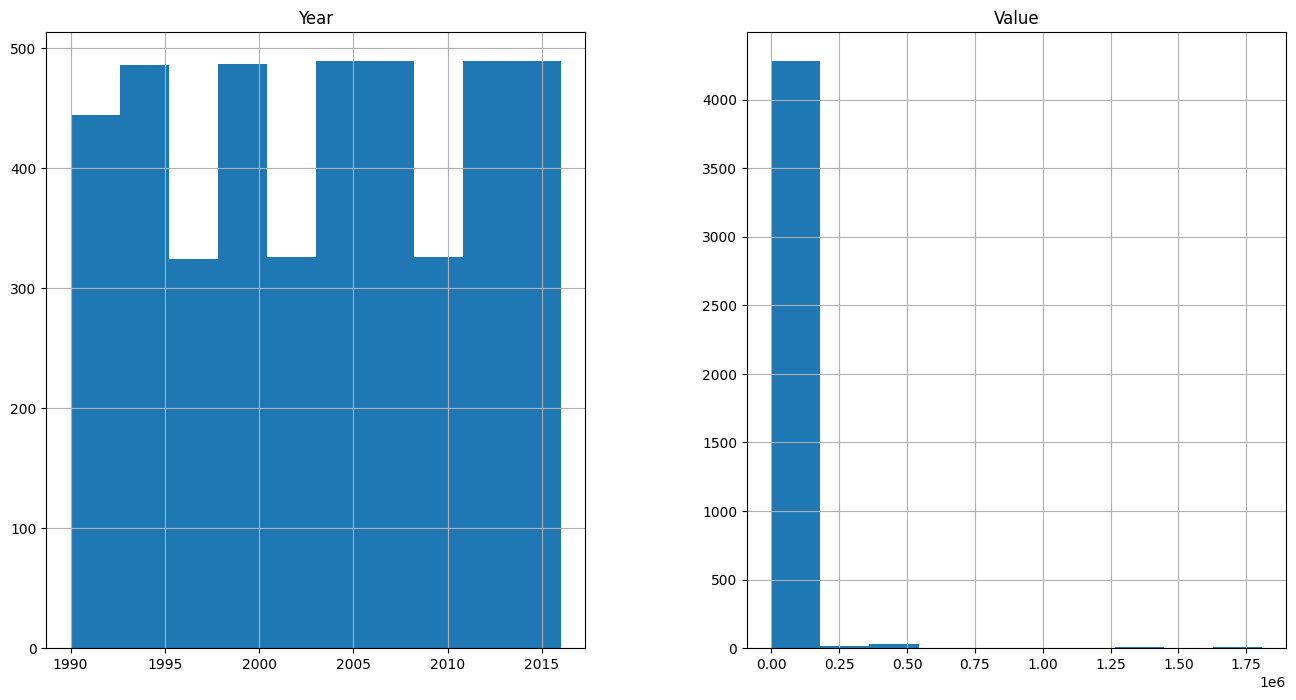

In [11]:
pesticides.hist(figsize=(16, 8));

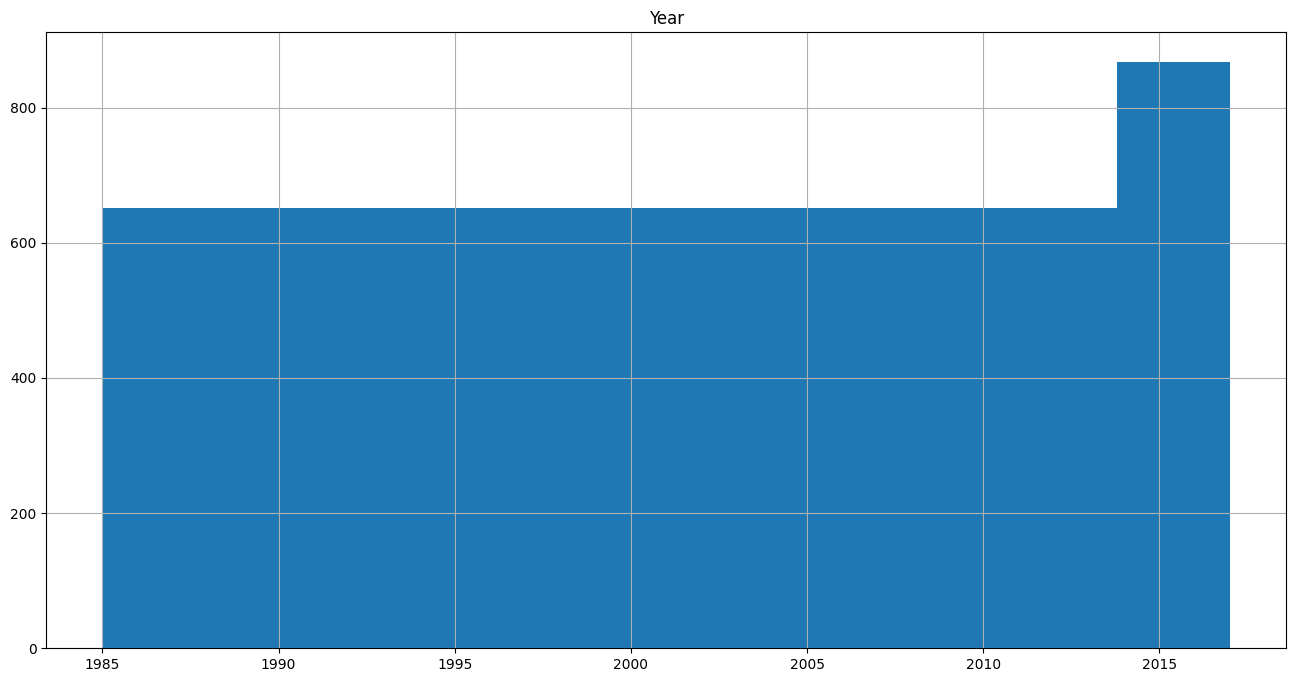

In [12]:
rainfall.hist(figsize=(16, 8));

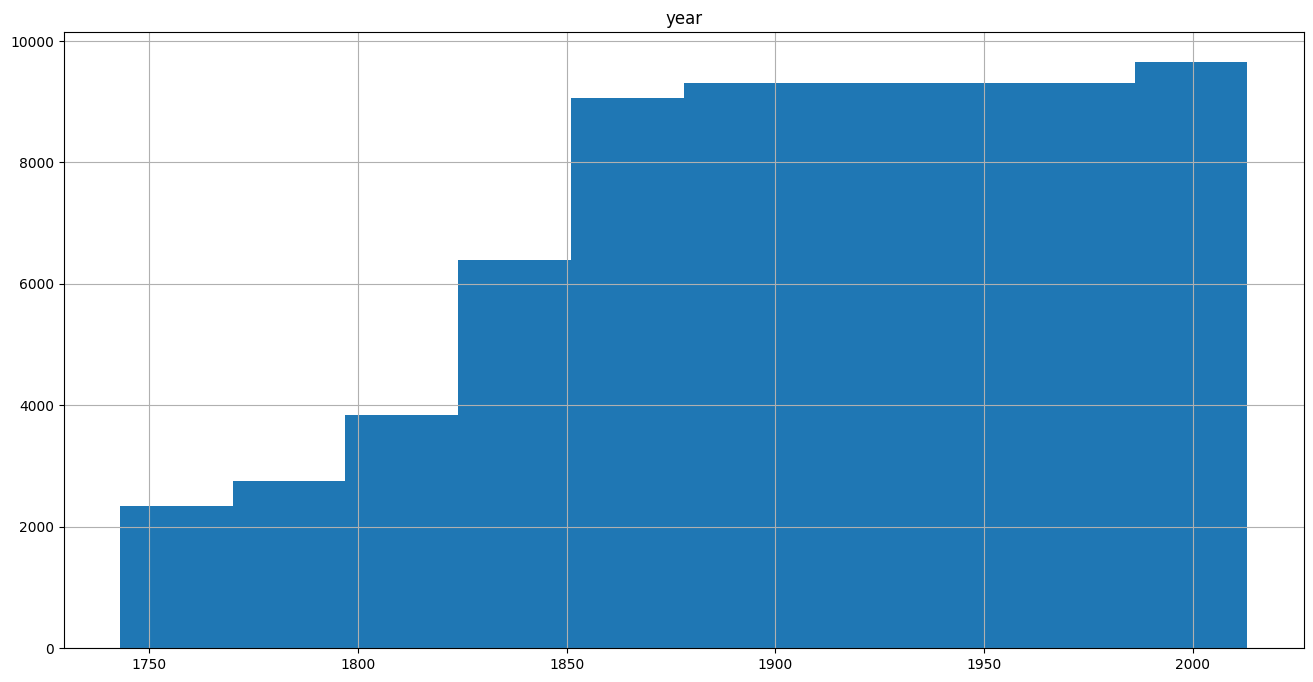

In [13]:
temp.hist(figsize=(16, 8));

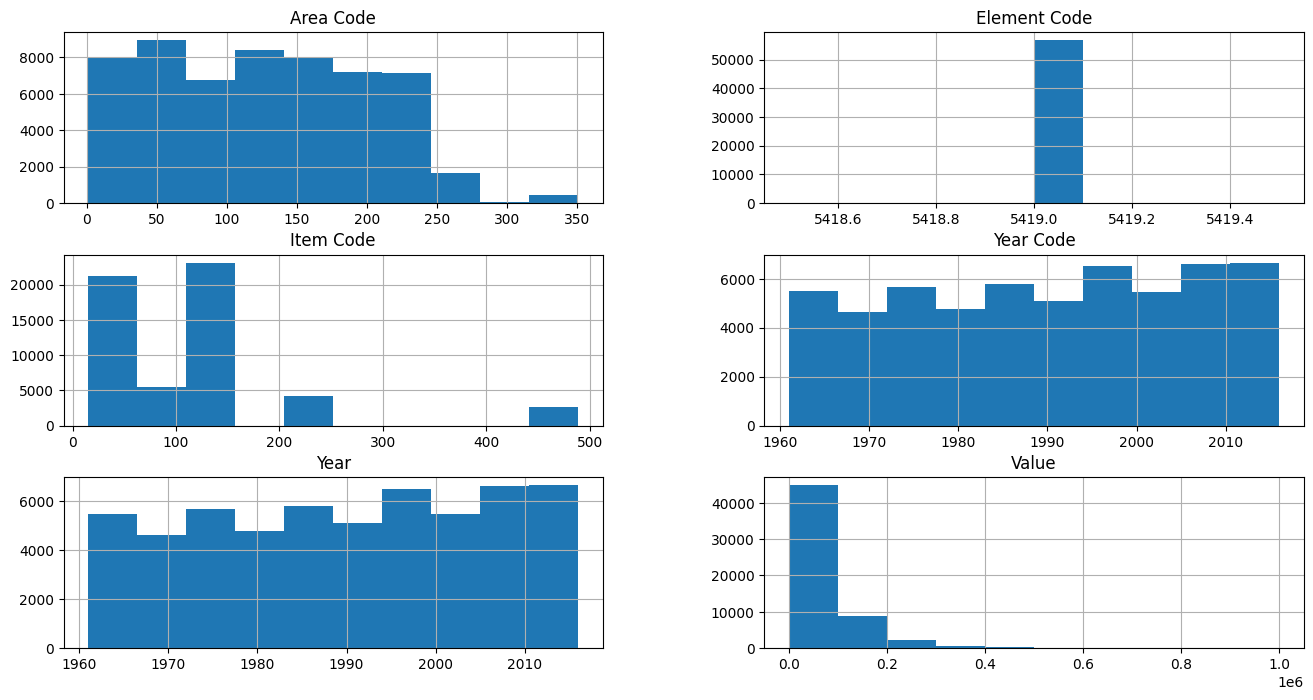

In [14]:
yield_df.hist(figsize=(16, 8));

## Intermediate conclusion

* Some datasets have missing values.
* Dtypes should be updated in a lot of cases.
* Outliers are also present and should be processed.
* Column names should be transferred to the lowercase.

# Step 2: Data Preprocessing

### 2.1 Optimizing the `pesticides` data-frame

In [15]:
pesticides.describe()

,Year,Value
count,4349.000000,4.349000e+03
mean,2003.138883,2.030334e+04
std,7.728044,1.177362e+05
min,1990.000000,0.000000e+00
25%,1996.000000,9.300000e+01
50%,2003.000000,1.137560e+03
75%,2010.000000,7.869000e+03
max,2016.000000,1.807000e+06


#### Remove unnecessary columns

In [16]:
pesticides.head()

,Domain,Area,Element,Item,Year,Unit,Value
0,Pesticides Use,Albania,Use,Pesticides (total),1990,tonnes of active ingredients,121.0
1,Pesticides Use,Albania,Use,Pesticides (total),1991,tonnes of active ingredients,121.0
2,Pesticides Use,Albania,Use,Pesticides (total),1992,tonnes of active ingredients,121.0
3,Pesticides Use,Albania,Use,Pesticides (total),1993,tonnes of active ingredients,121.0
4,Pesticides Use,Albania,Use,Pesticides (total),1994,tonnes of active ingredients,201.0


In [17]:
pesticides['Domain'].unique()

array(['Pesticides Use'], dtype=object)

In [18]:
pesticides['Area'].unique()

array(['Albania', 'Algeria', 'Angola', 'Antigua and Barbuda', 'Argentina',
       'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas',
       'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium',
       'Belgium-Luxembourg', 'Belize', 'Bermuda', 'Bhutan',
       'Bolivia (Plurinational State of)', 'Botswana', 'Brazil',
       'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi',
       'Cabo Verde', 'Cameroon', 'Canada', 'Central African Republic',
       'Chad', 'Chile', 'China, Hong Kong SAR', 'China, Macao SAR',
       'China, mainland', 'China, Taiwan Province of', 'Colombia',
       'Comoros', 'Congo', 'Cook Islands', 'Costa Rica', "Côte d'Ivoire",
       'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Dominican Republic',
       'Ecuador', 'Egypt', 'El Salvador', 'Eritrea', 'Estonia',
       'Ethiopia', 'Fiji', 'Finland', 'France', 'French Polynesia',
       'Gambia', 'Germany', 'Ghana', 'Greece', 'Guatemala', 'Guinea',
       'Guinea-Bissau', 'Guyana', 'Haiti', 'Ho

In [19]:
pesticides['Element'].unique()

array(['Use'], dtype=object)

In [20]:
pesticides['Item'].unique()

array(['Pesticides (total)'], dtype=object)

In [21]:
pesticides['Year'].unique()

array([1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
       2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016])

In [22]:
pesticides['Unit'].unique()

array(['tonnes of active ingredients'], dtype=object)

We can see that the following columns could be easily removed:
1. Domain
2. Item
3. Unit
4. Element

In [23]:
pesticides.drop(columns=(['Item', 'Unit', 'Domain', 'Element']), inplace=True)

#### Transform column names to the lowercase

In [24]:
pesticides.columns = map(str.lower, pesticides.columns)

#### Remove outliers

In this case we will not remove outliers because it seems that they are not actually outliers. These values are heavily dependent by country area and country development.

In [25]:
pesticides[pesticides.value > 100000].sample(10)

,area,year,value
906,"China, mainland",2011,1787002.00
4142,United States of America,2003,417758.24
129,Argentina,2011,100424.62
4135,United States of America,1996,433180.36
4151,United States of America,2012,407779.20
556,Brazil,2012,346583.00
4132,United States of America,1993,391903.86
541,Brazil,1997,110276.11
560,Brazil,2016,377176.00
543,Brazil,1999,127585.00


#### Rename the columns:

In [26]:
pesticides.columns = ['country', 'year', 'pest_amount']

#### Clean the country names

In [27]:
# Standardizing to double quotes within the strings
pesticides['country'] = pesticides['country'].str.replace("'", '"')

#### Transfrom data types

In [28]:
pesticides.pest_amount = pesticides.pest_amount.astype('float32')
pesticides.year = pesticides.year.astype('int16')
pesticides.country = pesticides.country.astype('string')

In [29]:
pesticides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4349 entries, 0 to 4348
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   country      4349 non-null   string 
 1   year         4349 non-null   int16  
 2   pest_amount  4349 non-null   float32
dtypes: float32(1), int16(1), string(1)
memory usage: 59.6 KB


In [30]:
print(f'We have reduced the memory usage of this dataset by: {round(((238-59.6)/238) * 100, 2)} %, from 238 KB to 59.6 KB ')

We have reduced the memory usage of this dataset by: 74.96 %, from 238 KB to 59.6 KB 


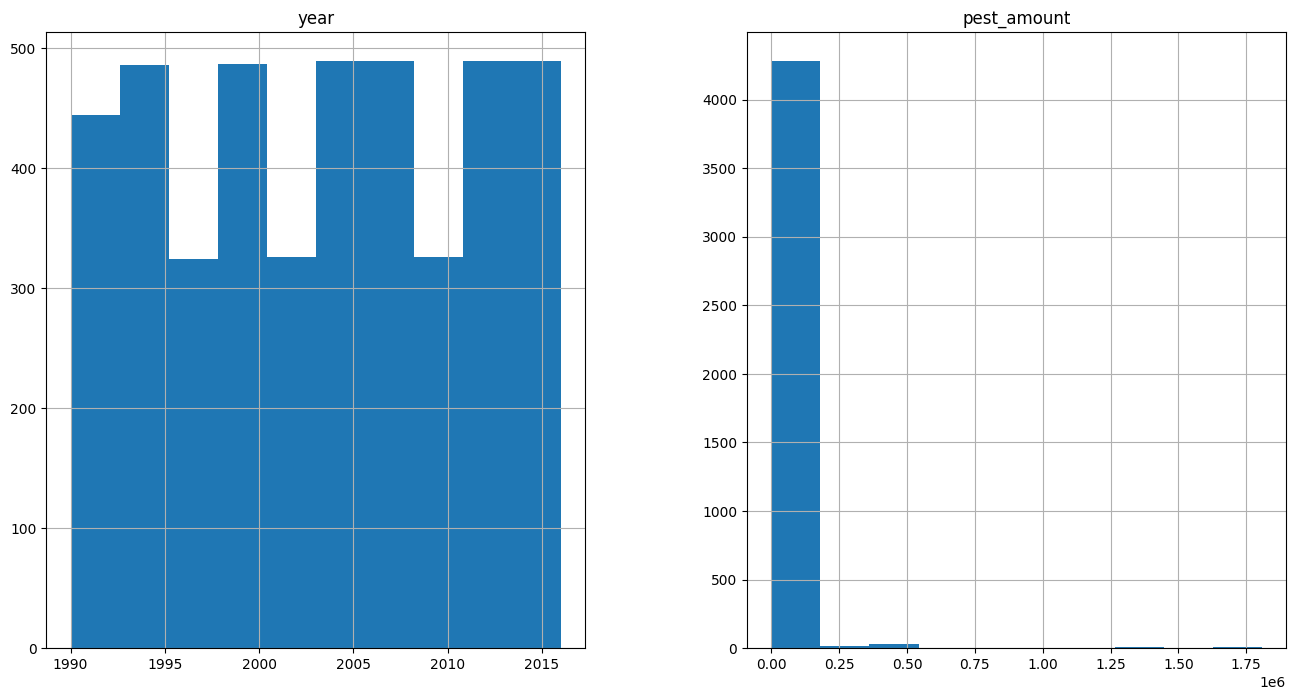

In [31]:
pesticides.hist(figsize=(16, 8));

### 2.2 Optimizing the `rainfall` data-frame

#### Transform column names to the lowercase

In [32]:
rainfall.columns = map(str.lower, rainfall.columns)

#### Rename the columns:

In [33]:
rainfall.columns = ['country', 'year', 'avg_prec_mm']

#### Transfrom data types

In [34]:
rainfall.avg_prec_mm.unique()

array(['327', '1485', '89', nan, '1010,0', '1010,1', '1010,2', '1010,3',
       '1010,4', '1010,5', '1010,6', '1010,7', '1010,8', '1010,9',
       '1010,10', '1010,11', '1010,12', '1010,13', '1010,14', '1010,15',
       '1010,16', '1010,17', '1010,18', '1010,19', '1010,20', '1010,21',
       '1010,22', '1010,23', '1010,24', '1010,25', '1010,26', '1010,27',
       '1010,28', '1010,29', '1010,30', '1010,31', '1010,32', '1010,33',
       '1010,34', '1010,35', '1010,36', '1010,37', '1010,38', '1010',
       '1030', '591', '562', '534', '1110', '447', '..', '1292', '83',
       '2666', '1422', '618', '847', '1705', '1039', '2200', '1146',
       '1028', '416', '1761', '2722', '608', '748', '1274', '228', '1904',
       '1604', '537', '1342', '322', '1522', '645', '3240', '900', '1543',
       '1646', '2926', '1348', '1113', '1335', '498', '677', '703', '220',
       '2083', '1410', '2274', '51', '1784', '2156', '383', '626', '788',
       '848', '2592', '536', '867', '1831', '836', '1026', 

In [35]:
# Convert 'nan' to empty string and '..' to empty string
rainfall['avg_prec_mm'] = rainfall['avg_prec_mm'].replace(np.nan, '').replace('..', '')

# Replace commas with periods to prepare for conversion to float
rainfall['avg_prec_mm'] = rainfall['avg_prec_mm'].str.replace(',', '.')

# Convert to float
rainfall['avg_prec_mm'] = pd.to_numeric(rainfall['avg_prec_mm'], errors='coerce')

##### We have some missing data here, but let's now leave it in the dataset

In [36]:
rainfall['avg_prec_mm'].isna().sum()

780

In [37]:
rainfall.year = rainfall.year.astype('int16')
rainfall.country = rainfall.country.astype('string')

In [38]:
rainfall.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6727 entries, 0 to 6726
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   country      6727 non-null   string 
 1   year         6727 non-null   int16  
 2   avg_prec_mm  5947 non-null   float64
dtypes: float64(1), int16(1), string(1)
memory usage: 118.4 KB


In [39]:
print(f'We have reduced the memory usage of this dataset by: {round(((157.8-118.4)/157.8) * 100, 2)} %, from 238 KB to 59.6 KB ')

We have reduced the memory usage of this dataset by: 24.97 %, from 238 KB to 59.6 KB 


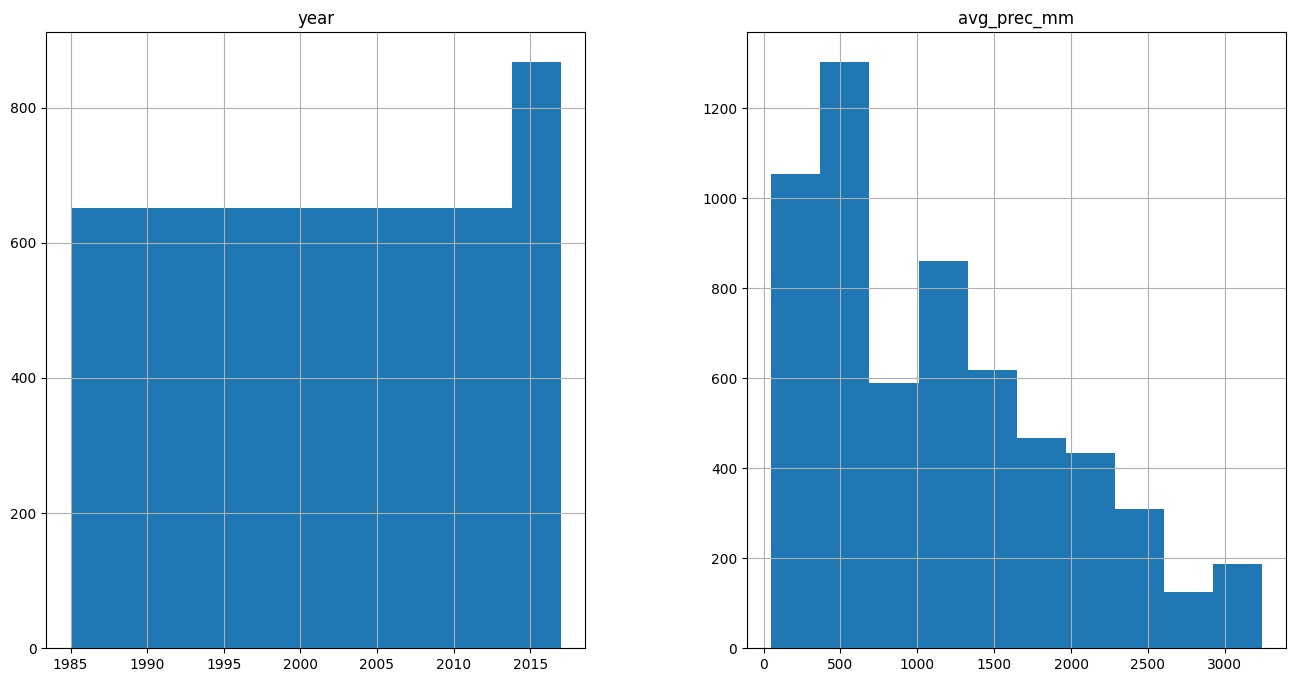

In [40]:
rainfall.hist(figsize=(16, 8));

### 2.2 Optimizing the `temp` data-frame

In [41]:
temp.head()

,year,country,avg_temp
0,1849,Côte D'Ivoire,25.58
1,1850,Côte D'Ivoire,25.52
2,1851,Côte D'Ivoire,25.67
3,1852,Côte D'Ivoire,NaN
4,1853,Côte D'Ivoire,NaN


In [42]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71311 entries, 0 to 71310
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   year      71311 non-null  int64 
 1   country   71311 non-null  object
 2   avg_temp  68774 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.6+ MB


In [43]:
temp.describe()

,year
count,71311.000000
mean,1905.799007
std,67.102099
min,1743.000000
25%,1858.000000
50%,1910.000000
75%,1962.000000
max,2013.000000


#### Rename the columns:

In [44]:
temp.columns = ['year', 'country', 'avg_temp']

#### Clean the country names

In [45]:
temp.country.unique()

array(["Côte D'Ivoire", 'United Arab Emirates', 'Nigeria', 'Ghana',
       'Turkey', 'Australia', 'India', 'United States', 'Egypt',
       'Algeria', 'Kazakhstan', 'Netherlands', 'China', 'Madagascar',
       'Eritrea', 'Greece', 'Iraq', 'Azerbaijan', 'Mali', 'Indonesia',
       'Thailand', 'Central African Republic', 'Spain', 'Venezuela',
       'Colombia', 'Lebanon', 'United Kingdom', 'Serbia', 'Brazil',
       'Libya', 'Germany', 'Switzerland', 'Guinea Bissau', 'Slovakia',
       'Congo', 'Belgium', 'Romania', 'Hungary', 'Burundi', 'Morocco',
       'Russia', 'Moldova', 'Sri Lanka', 'Guinea', 'Denmark', 'Argentina',
       'Senegal', 'Syria', 'Tanzania', 'Bangladesh', 'Qatar', 'Cameroon',
       'Ireland', 'South Africa', 'Tajikistan', 'Mexico', 'Pakistan',
       'Sierra Leone', 'Botswana', 'Guyana', 'Guatemala', 'Ecuador',
       'Vietnam', 'Zimbabwe', 'Finland', 'Japan', 'Sudan', 'Afghanistan',
       'Uganda', 'Taiwan', 'Nepal', 'Ukraine', 'Rwanda', 'Canada',
       'Jamaica', 

In [46]:
# Standardizing to double quotes within the strings
temp['country'] = temp['country'].str.replace("'", '"')

#### Cleaning the `avg_temp` column

In [47]:
temp.avg_temp.unique()

array(['25.58', '25.52', '25.67', ..., '9.10E+00', '1.03E+01', '9.00E+00'],
      dtype=object)

In [48]:
# Handle the 'nan' and 'none' values
temp['avg_temp'] = temp['avg_temp'].replace(np.nan, '').replace('none', '')

# Convert the entire column to float, handling empty strings by converting them to NaN
temp['avg_temp'] = temp['avg_temp'].apply(lambda x: float(x) if x != '' else np.nan)

#### Transfrom data types

In [49]:
temp.year = temp.year.astype('int16')
temp.country = temp.country.astype('string')
temp.avg_temp = temp.avg_temp.astype('float16')

In [50]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71311 entries, 0 to 71310
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   year      71311 non-null  int16  
 1   country   71311 non-null  string 
 2   avg_temp  68764 non-null  float16
dtypes: float16(1), int16(1), string(1)
memory usage: 835.8 KB


In [51]:
original_memory_kb = 1638.4  # MB converted to KB
reduced_memory_kb = 835.8

reduction_percentage = ((original_memory_kb - reduced_memory_kb) / original_memory_kb) * 100
reduction_percentage = round(reduction_percentage, 2)  # Round to two decimal places

print(f'We have reduced the memory usage of this dataset by: {reduction_percentage}%, from 1.6 MB to 835.8 KB ')

We have reduced the memory usage of this dataset by: 48.99%, from 1.6 MB to 835.8 KB 


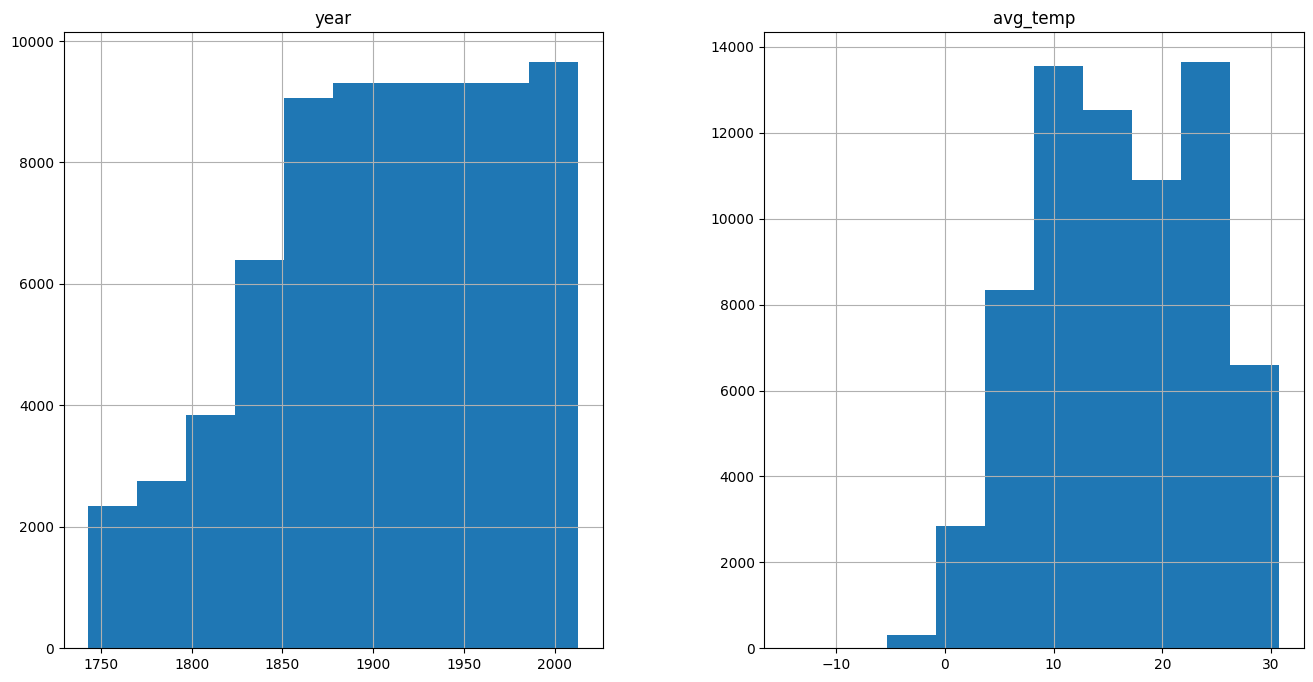

In [52]:
temp.hist(figsize=(16, 8));

### 2.2 Optimizing the `yield_df` data-frame

In [53]:
yield_df.head()

,Domain Code,Domain,Area Code,Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value
0,QC,Crops,2,Afghanistan,5419,Yield,56,Maize,1961,1961,hg/ha,14000
1,QC,Crops,2,Afghanistan,5419,Yield,56,Maize,1962,1962,hg/ha,14000
2,QC,Crops,2,Afghanistan,5419,Yield,56,Maize,1963,1963,hg/ha,14260
3,QC,Crops,2,Afghanistan,5419,Yield,56,Maize,1964,1964,hg/ha,14257
4,QC,Crops,2,Afghanistan,5419,Yield,56,Maize,1965,1965,hg/ha,14400


In [54]:
yield_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56717 entries, 0 to 56716
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Domain Code   56717 non-null  object
 1   Domain        56717 non-null  object
 2   Area Code     56717 non-null  int64 
 3   Area          56717 non-null  object
 4   Element Code  56717 non-null  int64 
 5   Element       56717 non-null  object
 6   Item Code     56717 non-null  int64 
 7   Item          56717 non-null  object
 8   Year Code     56717 non-null  int64 
 9   Year          56717 non-null  int64 
 10  Unit          56717 non-null  object
 11  Value         56717 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 5.2+ MB


In [55]:
yield_df.describe()

,Area Code,Element Code,Item Code,Year Code,Year,Value
count,56717.000000,56717.0,56717.000000,56717.000000,56717.000000,56717.000000
mean,125.650422,5419.0,111.611651,1989.669570,1989.669570,62094.660084
std,75.120195,0.0,101.278435,16.133198,16.133198,67835.932856
min,1.000000,5419.0,15.000000,1961.000000,1961.000000,0.000000
25%,58.000000,5419.0,56.000000,1976.000000,1976.000000,15680.000000
50%,122.000000,5419.0,116.000000,1991.000000,1991.000000,36744.000000
75%,184.000000,5419.0,125.000000,2004.000000,2004.000000,86213.000000
max,351.000000,5419.0,489.000000,2016.000000,2016.000000,1000000.000000


#### Unique values in columns

In [56]:
yield_df['Domain Code'].unique()

array(['QC'], dtype=object)

In [57]:
yield_df['Domain'].unique()

array(['Crops'], dtype=object)

In [58]:
yield_df['Area Code'].unique()

array([  2,   3,   4,   5,   7,   8,   9,   1,  10,  11,  52,  12,  13,
        16,  14,  57, 255,  15,  23,  53,  17,  18,  19,  80,  20,  21,
        26,  27, 233,  29,  35, 115,  32,  33,  36,  37,  39,  40, 351,
        96,  41, 214,  44,  45,  46,  47,  48, 107,  98,  49,  50, 167,
        51, 116, 250,  54,  72,  55,  56,  58,  59,  60,  61, 178,  63,
       238,  62,  64,  66,  67,  68,  69,  70,  74,  75,  73,  79,  81,
        84,  86,  87,  88,  89,  90, 175,  91,  93,  95,  97,  99, 100,
       101, 102, 103, 104, 105, 106, 109, 110, 112, 108, 114, 118, 113,
       120, 119, 121, 122, 123, 124, 126, 256, 129, 130, 131, 132, 133,
       134, 135, 136, 137, 138, 145, 141, 273, 142, 143, 144,  28, 147,
       149, 150, 153, 156, 157, 158, 159, 160, 162, 299, 221, 164, 165,
       166, 168, 169, 170, 171, 173, 174, 177, 179, 117, 146, 182, 183,
       185, 184, 188, 189, 191, 244, 193, 194, 195, 272, 186, 196, 197,
       200, 199, 198,  25, 201, 202, 277, 203,  38, 276, 206, 20

In [59]:
yield_df['Area'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'American Samoa', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Belgium-Luxembourg', 'Belize',
       'Benin', 'Bermuda', 'Bhutan', 'Bolivia (Plurinational State of)',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi',
       'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada', 'Cayman Islands',
       'Central African Republic', 'Chad', 'Chile', 'China',
       'China, Hong Kong SAR', 'China, mainland',
       'China, Taiwan Province of', 'Colombia', 'Comoros', 'Congo',
       'Cook Islands', 'Costa Rica', "Côte d'Ivoire", 'Croatia', 'Cuba',
       'Cyprus', 'Czechia', 'Czechoslovakia',
       "Democratic People's Republic of Korea",
       'Democratic Republic of the Congo', 'Denmark', 'Djibouti',
       'Dominica', 'Dominican Republic',

In [60]:
yield_df['Element Code'].unique()

array([5419])

In [61]:
yield_df['Element'].unique()

array(['Yield'], dtype=object)

In [62]:
yield_df['Item Code'].unique()

array([ 56, 116,  27,  15,  83, 236, 125, 137, 122, 489])

In [63]:
yield_df['Item'].unique()

array(['Maize', 'Potatoes', 'Rice, paddy', 'Wheat', 'Sorghum', 'Soybeans',
       'Cassava', 'Yams', 'Sweet potatoes', 'Plantains and others'],
      dtype=object)

In [64]:
yield_df['Unit'].unique()

array(['hg/ha'], dtype=object)

#### Remove the redundant columns

In [65]:
yield_df.drop(columns=(['Domain Code', 'Domain', 'Area Code', 'Element Code', 'Element', 'Item Code', 'Unit', 'Year Code']), inplace=True)

#### Rename the columns:

In [66]:
yield_df.columns = ['country', 'item', 'year', 'value']

#### Clean the country names

In [67]:
# Standardizing to double quotes within the strings
yield_df['country'] = yield_df['country'].str.replace("'", '"')

In [68]:
yield_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56717 entries, 0 to 56716
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   country  56717 non-null  object
 1   item     56717 non-null  object
 2   year     56717 non-null  int64 
 3   value    56717 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 1.7+ MB


In [69]:
yield_df.head()

,country,item,year,value
0,Afghanistan,Maize,1961,14000
1,Afghanistan,Maize,1962,14000
2,Afghanistan,Maize,1963,14260
3,Afghanistan,Maize,1964,14257
4,Afghanistan,Maize,1965,14400


#### Transfrom data types

In [70]:
yield_df.year = yield_df.year.astype('int16')
yield_df.country = yield_df.country.astype('string')
yield_df.value = yield_df.value.astype('int32')
yield_df.item = yield_df.item.astype('category')

In [71]:
yield_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56717 entries, 0 to 56716
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   country  56717 non-null  string  
 1   item     56717 non-null  category
 2   year     56717 non-null  int16   
 3   value    56717 non-null  int32   
dtypes: category(1), int16(1), int32(1), string(1)
memory usage: 831.3 KB


In [72]:
original_memory_kb = 5324.8  # MB converted to KB
reduced_memory_kb = 831.3

reduction_percentage = ((original_memory_kb - reduced_memory_kb) / original_memory_kb) * 100
reduction_percentage = round(reduction_percentage, 2)  # Round to two decimal places

print(f'We have reduced the memory usage of this dataset by: {reduction_percentage}%, from 5.2 MB to 831.3 KB ')

We have reduced the memory usage of this dataset by: 84.39%, from 5.2 MB to 831.3 KB 


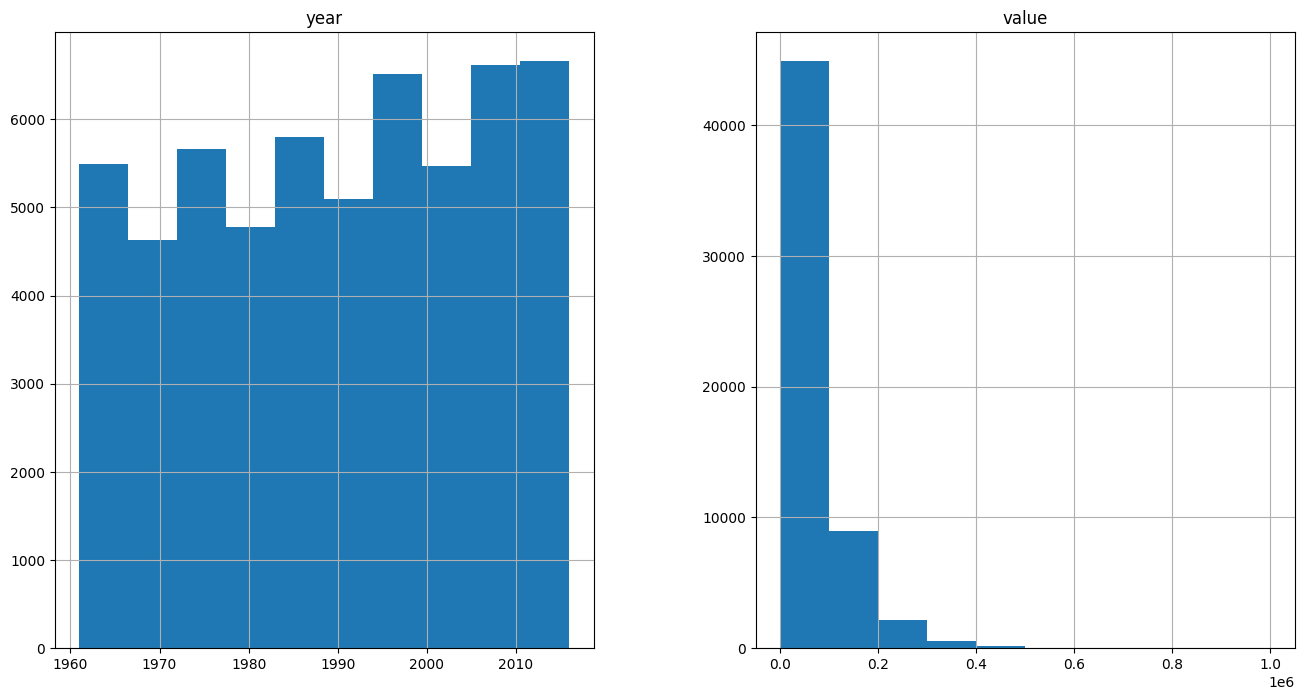

In [73]:
yield_df.hist(figsize=(16, 8));

# Step 3: Merging the data

## 3.1 Standardizing the country names

In [74]:
# Aggregate all unique country names
unique_names = set(pesticides['country'].unique()).union(
    rainfall['country'].unique(),
    yield_df['country'].unique(),
    temp['country'].unique()
)

In [75]:
# Get standard correct names for all countries
data = countries.all_countries()
standard_country_names = data.countries() 

In [76]:
# Create a mapping of names based on closest match
def create_name_mapping(unknown_names, known_names):
    mapping = {}
    for name in unknown_names:
        closest_match = process.extractOne(name, known_names)
        mapping[name] = closest_match[0]  # assuming closest_match is not None
    return mapping

name_mapping = create_name_mapping(unique_names, standard_country_names)

# Apply this mapping to each DataFrame
pesticides['country'] = pesticides['country'].replace(name_mapping)
rainfall['country'] = rainfall['country'].replace(name_mapping)
yield_df['country'] = yield_df['country'].replace(name_mapping)
temp['country'] = temp['country'].replace(name_mapping)

## 3.2 Standardizing the years range in all datasets

The main dataset is `yield_df`, let's focus on its years range.

In [77]:
min_year = yield_df.year.min()
max_year = yield_df.year.max()

pesticides = pesticides[(pesticides.year >= min_year) & (pesticides.year <= max_year)]
rainfall = rainfall[(rainfall.year >= min_year) & (rainfall.year <= max_year)]
temp = temp[(temp.year >= min_year) & (temp.year <= max_year)]

## 3.3 Merge the datasets

#### Merge the `yield_df` df with the `temp` df

In [78]:
merged_df = pd.merge(yield_df, temp, how='left', on=['country', 'year'])

In [79]:
merged_df.head()

,country,item,year,value,avg_temp
0,Afghanistan,Maize,1961,14000,14.226562
1,Afghanistan,Maize,1962,14000,14.101562
2,Afghanistan,Maize,1963,14260,15.007812
3,Afghanistan,Maize,1964,14257,13.726562
4,Afghanistan,Maize,1965,14400,13.898438


#### Merge the resulting dataframe with the `pesticides` df

In [80]:
merged_df = pd.merge(merged_df, pesticides, how='left', on=['country', 'year'])

In [81]:
merged_df.head()

,country,item,year,value,avg_temp,pest_amount
0,Afghanistan,Maize,1961,14000,14.226562,NaN
1,Afghanistan,Maize,1962,14000,14.101562,NaN
2,Afghanistan,Maize,1963,14260,15.007812,NaN
3,Afghanistan,Maize,1964,14257,13.726562,NaN
4,Afghanistan,Maize,1965,14400,13.898438,NaN


In [82]:
pesticides[pesticides.country == 'Afghanistan'].head()

,country,year,pest_amount


#### Merge the resulting dataframe with the `rainfall` df

In [83]:
merged_df = pd.merge(merged_df, rainfall, how='left', on=['country', 'year'])

In [84]:
rainfall.head()

,country,year,avg_prec_mm
0,Afghanistan,1985,327.0
1,Afghanistan,1986,327.0
2,Afghanistan,1987,327.0
3,Afghanistan,1989,327.0
4,Afghanistan,1990,327.0


In [85]:
merged_df.head()

,country,item,year,value,avg_temp,pest_amount,avg_prec_mm
0,Afghanistan,Maize,1961,14000,14.226562,NaN,NaN
1,Afghanistan,Maize,1962,14000,14.101562,NaN,NaN
2,Afghanistan,Maize,1963,14260,15.007812,NaN,NaN
3,Afghanistan,Maize,1964,14257,13.726562,NaN,NaN
4,Afghanistan,Maize,1965,14400,13.898438,NaN,NaN


#### Rename the columns

In [86]:
merged_df.columns = ['country', 'crop_type', 'year', 'crop_yield', 'avg_temp', 'pest_used_tonnes', 'avg_prec_mm']

In [87]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414465 entries, 0 to 414464
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   country           414465 non-null  string  
 1   crop_type         414465 non-null  category
 2   year              414465 non-null  int16   
 3   crop_yield        414465 non-null  int32   
 4   avg_temp          396029 non-null  float16 
 5   pest_used_tonnes  308991 non-null  float32 
 6   avg_prec_mm       159181 non-null  float64 
dtypes: category(1), float16(1), float32(1), float64(1), int16(1), int32(1), string(1)
memory usage: 11.5 MB


## 3.4 Add regions

In [88]:
# Retrieve all country data
all_countries = countries.all_countries()

# Retrieve regions from the data
regions_list = all_countries.regions()

# Create a dictionary where the key is the country and the value is the region
country_region_dict = {country['country']: country['location'] for country in regions_list}

# Map the regions to your DataFrame using the created dictionary
merged_df['region'] = merged_df['country'].map(country_region_dict)

merged_df['region'] = merged_df['region'].astype('category')
merged_df['country'] = merged_df['country'].astype('category')

In [89]:
merged_df.sample(10)

,country,crop_type,year,crop_yield,avg_temp,pest_used_tonnes,avg_prec_mm,region
385457,Turkey,Maize,1981,20690,12.078125,NaN,NaN,Middle East
171685,China,Sorghum,1995,39144,12.453125,9954.000000,NaN,Eastern Asia
79763,China,Soybeans,2002,18929,11.382812,84.000000,NaN,Eastern Asia
286850,China,Sweet potatoes,2013,222710,17.859375,9632.000000,NaN,Eastern Asia
375263,India,Potatoes,2000,20000,24.562500,44957.519531,788.0,Southern and Central Asia
250643,China,"Rice, paddy",2004,60486,6.671875,51.000000,NaN,Eastern Asia
6852,Benin,Cassava,2006,128689,NaN,NaN,1039.0,Western Africa
343100,Mexico,Potatoes,1969,103539,19.593750,NaN,NaN,Central America
280767,China,Sweet potatoes,1998,193029,5.890625,17.150000,NaN,Eastern Asia
193318,China,Sweet potatoes,1995,192572,12.812500,17.150000,645.0,Eastern Asia


In [90]:
merged_df[merged_df['region'].isna()].sample(10)

,country,crop_type,year,crop_yield,avg_temp,pest_used_tonnes,avg_prec_mm,region
365485,Saint Vincent And The Grenadines,Yams,1984,100000,NaN,NaN,NaN,NaN
364864,Saint Kitts And Nevis,Yams,1984,52500,NaN,NaN,NaN,NaN
385084,Trinidad And Tobago,Sweet potatoes,1970,33628,NaN,NaN,NaN,NaN
363921,Russia,Soybeans,2004,9981,3.789062,25961.000000,460.0,NaN
303544,Congo The Democratic Republic Of The,"Rice, paddy",2003,7550,21.437500,24610.000000,NaN,NaN
5204,Bahamas The,Maize,2003,34000,25.812500,319.109985,NaN,NaN
363976,Russia,Soybeans,2010,11796,10.382812,25961.000000,460.0,NaN
304008,Congo The Democratic Republic Of The,Yams,1963,75000,24.203125,NaN,NaN,NaN
358049,Papua new Guinea,"Rice, paddy",1963,32000,24.750000,NaN,NaN,NaN
358086,Papua new Guinea,"Rice, paddy",2000,18910,25.406250,105.000000,3142.0,NaN


#### Some regions were not assigned. We will leave it as it is for now.

## 3.5 Handling missing values and duplicates

In this work I will leave the missing values as they are, since some datasets lack data on temperature, other lack some data for precipitation and so on. The process could be complicated and is out of scope in this research. This is not critical and I will use ML approach that handles missing values. 

In [91]:
len(merged_df)

414465

In [92]:
# Check for duplicate rows
merged_df.duplicated().sum()

129381

In [93]:
# Let's have a look on the complete duplicates
merged_df[merged_df.duplicated(keep=False)].sort_values(['country', 'year', 'crop_type']).head(10)

,country,crop_type,year,crop_yield,avg_temp,pest_used_tonnes,avg_prec_mm,region
5357,Bangladesh,Maize,1961,7988,25.71875,NaN,NaN,Southern and Central Asia
5358,Bangladesh,Maize,1961,7988,25.71875,NaN,NaN,Southern and Central Asia
5466,Bangladesh,Potatoes,1961,61491,25.71875,NaN,NaN,Southern and Central Asia
5467,Bangladesh,Potatoes,1961,61491,25.71875,NaN,NaN,Southern and Central Asia
5575,Bangladesh,"Rice, paddy",1961,17005,25.71875,NaN,NaN,Southern and Central Asia
5576,Bangladesh,"Rice, paddy",1961,17005,25.71875,NaN,NaN,Southern and Central Asia
5684,Bangladesh,Sorghum,1961,12559,25.71875,NaN,NaN,Southern and Central Asia
5685,Bangladesh,Sorghum,1961,12559,25.71875,NaN,NaN,Southern and Central Asia
5814,Bangladesh,Sweet potatoes,1961,89189,25.71875,NaN,NaN,Southern and Central Asia
5815,Bangladesh,Sweet potatoes,1961,89189,25.71875,NaN,NaN,Southern and Central Asia


#### The data was somehow duplicated. Let's remove the complete duplicates.

In [94]:
# drop the duplicates
merged_df.drop_duplicates(keep='first', inplace=True)

# Step 4: Explorative Data Analysis (EDA)

### Explanations about the `merged_df`:

#### Understanding the Unit "hg/ha"

The unit **"hg/ha"** stands for **hectograms per hectare**, which is a measure of yield or production density commonly used in agriculture. Here’s a breakdown of what each part of this unit represents:

- **Hectogram (hg)**: A metric unit of mass equal to one hundred grams, or \(0.1\) kilograms.
- **Hectare (ha)**: A metric unit of area that equals \(10,000\) square meters, or about \(2.47\) acres. It's commonly used to measure land area, especially in agriculture.

When the unit "hg/ha" is used, especially in the context of agricultural yields like for crops such as maize, it indicates the amount of crop produced per hectare of land. For example, a yield of \(14,000\) hg/ha means that each hectare of land used to grow maize produced \(14,000\) hectograms or \(1,400\) kilograms of maize. This metric is crucial for comparing the productivity of different plots of land or assessing the impact of various agricultural practices or inputs.




In [95]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 285084 entries, 0 to 414464
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   country           285084 non-null  category
 1   crop_type         285084 non-null  category
 2   year              285084 non-null  int16   
 3   crop_yield        285084 non-null  int32   
 4   avg_temp          266976 non-null  float16 
 5   pest_used_tonnes  193791 non-null  float32 
 6   avg_prec_mm       137620 non-null  float64 
 7   region            277336 non-null  category
dtypes: category(3), float16(1), float32(1), float64(1), int16(1), int32(1)
memory usage: 8.7 MB


In [96]:
merged_df.sample(10)

,country,crop_type,year,crop_yield,avg_temp,pest_used_tonnes,avg_prec_mm,region
91297,China,Sweet potatoes,2004,217398,6.671875,9.703000e+03,NaN,Eastern Asia
158890,China,"Rice, paddy",1990,57261,15.140625,9.954000e+03,645.0,Eastern Asia
196782,China,Sweet potatoes,2005,221836,7.750000,1.460000e+06,NaN,Eastern Asia
87293,China,Sweet potatoes,1994,177270,6.339844,9.785510e+05,645.0,Eastern Asia
176543,China,Sorghum,2008,37505,4.628906,2.837000e+01,NaN,Eastern Asia
117855,China,Sweet potatoes,1996,67500,3.500000,9.954000e+03,NaN,Eastern Asia
409550,Australia,Wheat,1977,13972,13.500000,NaN,NaN,Australia and New Zealand
140473,China,Maize,1998,52678,13.546875,1.715000e+01,NaN,Eastern Asia
409167,Australia,Sorghum,1979,11125,18.453125,NaN,NaN,Australia and New Zealand
224791,China,Maize,1993,52840,14.476562,8.448000e+05,645.0,Eastern Asia


In [97]:
merged_df.describe()

,year,crop_yield,avg_temp,pest_used_tonnes,avg_prec_mm
count,285084.000000,285084.000000,266976.000000,1.937910e+05,137620.000000
mean,1994.006963,79305.079496,NaN,2.582728e+05,870.657929
std,14.166881,72672.661072,0.000000,5.219600e+05,522.891880
min,1961.000000,0.000000,-4.238281,0.000000e+00,51.000000
25%,1986.000000,22913.000000,11.531250,4.600000e+01,645.000000
50%,1996.000000,50553.000000,15.968750,8.780000e+03,645.000000
75%,2005.000000,127034.000000,21.328125,5.611400e+04,788.000000
max,2016.000000,1000000.000000,30.734375,1.807000e+06,3240.000000


In [98]:
# Check for missing values
print(merged_df.isnull().sum())

country                  0
crop_type                0
year                     0
crop_yield               0
avg_temp             18108
pest_used_tonnes     91293
avg_prec_mm         147464
region                7748
dtype: int64


In [99]:
# Check for duplicate rows
merged_df.duplicated().sum()

0

In [100]:
# Check how many rows are assigned per each crop_type
merged_df['crop_type'].value_counts().to_frame().reset_index()

,crop_type,count
0,Sweet potatoes,40681
1,"Rice, paddy",40203
2,Maize,38021
3,Potatoes,37279
4,Sorghum,33482
5,Wheat,29551
6,Cassava,29082
7,Soybeans,28266
8,Yams,4834
9,Plantains and others,3685


### Correlation matrix

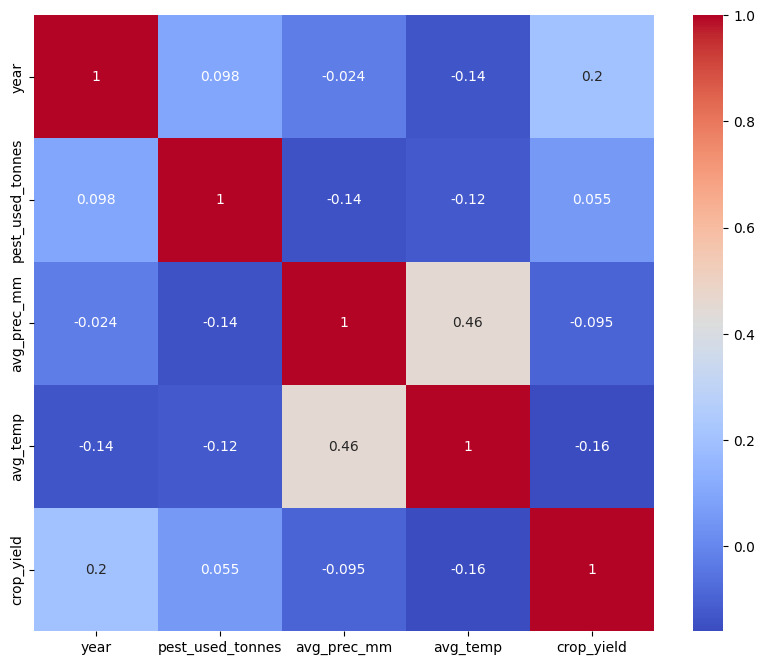

In [101]:
plt.figure(figsize=(10, 8))
correlation_matrix = merged_df[['year', 'pest_used_tonnes', 'avg_prec_mm', 'avg_temp', 'crop_yield']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

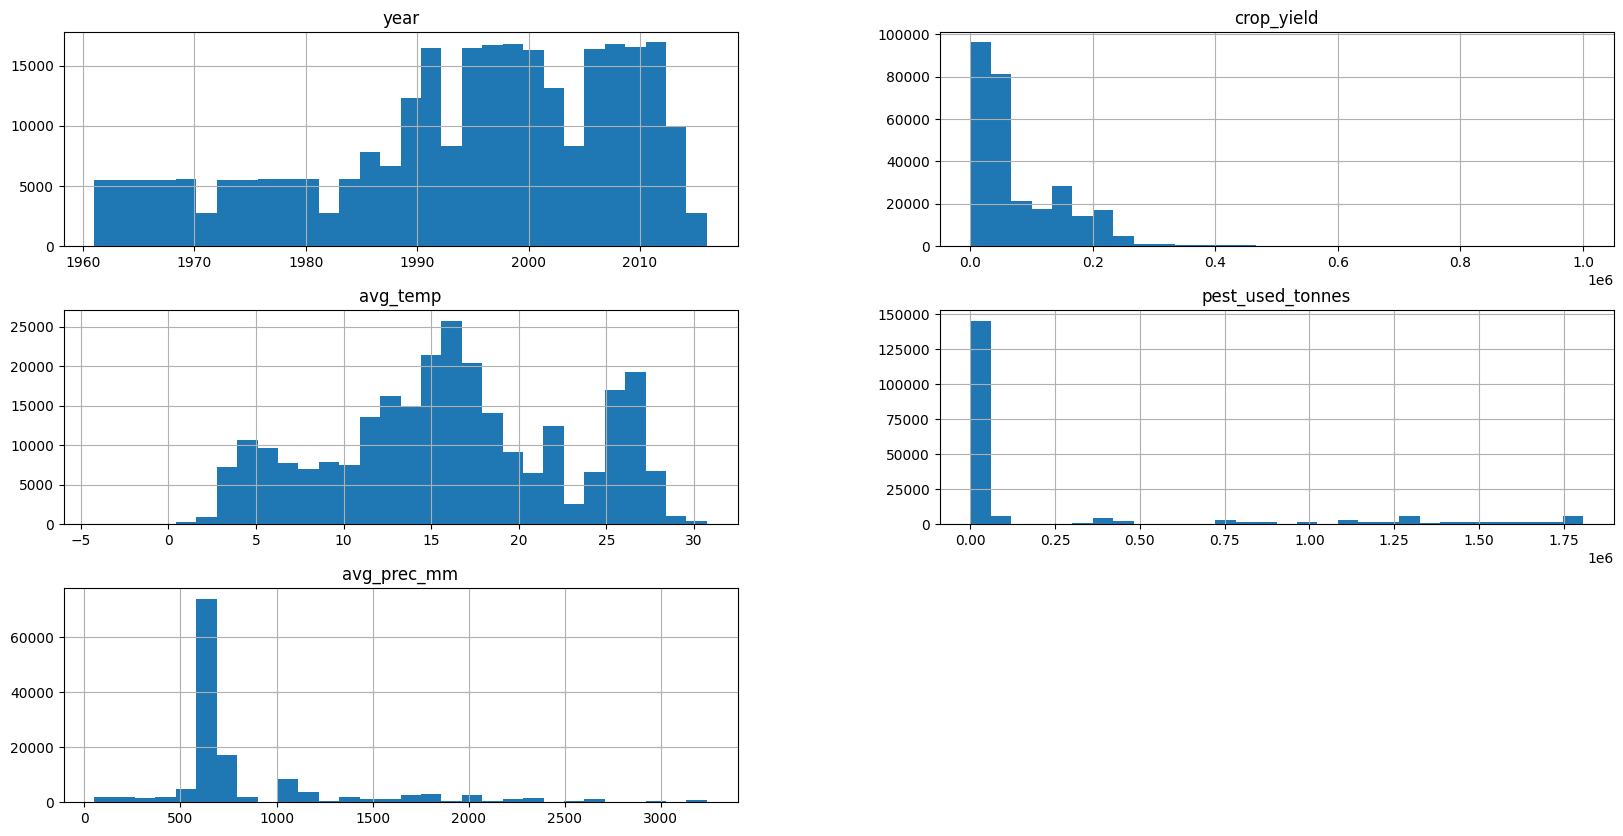

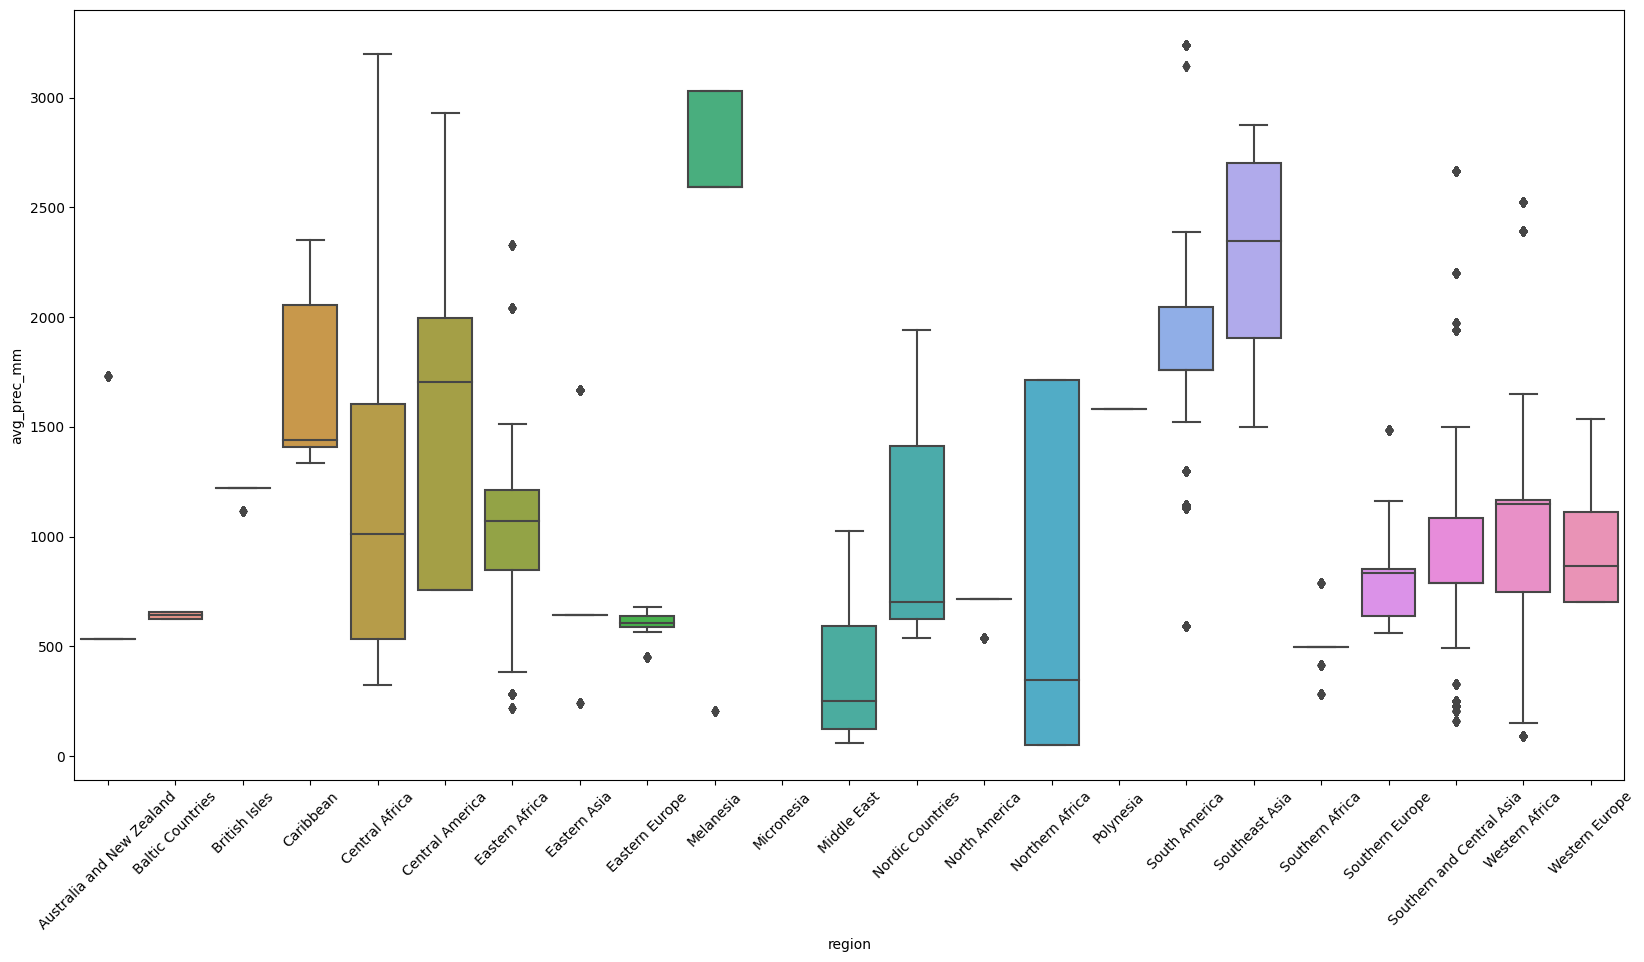

In [102]:
figsize = (20, 10)

# Histograms for each numerical attribute
merged_df.hist(bins=30, figsize=figsize)
plt.show()

# Boxplot for average precipitation
plt.figure(figsize=figsize)
sns.boxplot(x='region', y='avg_prec_mm', data=merged_df)
plt.xticks(rotation=45)
plt.show()

### Average Temperature per Region per Year

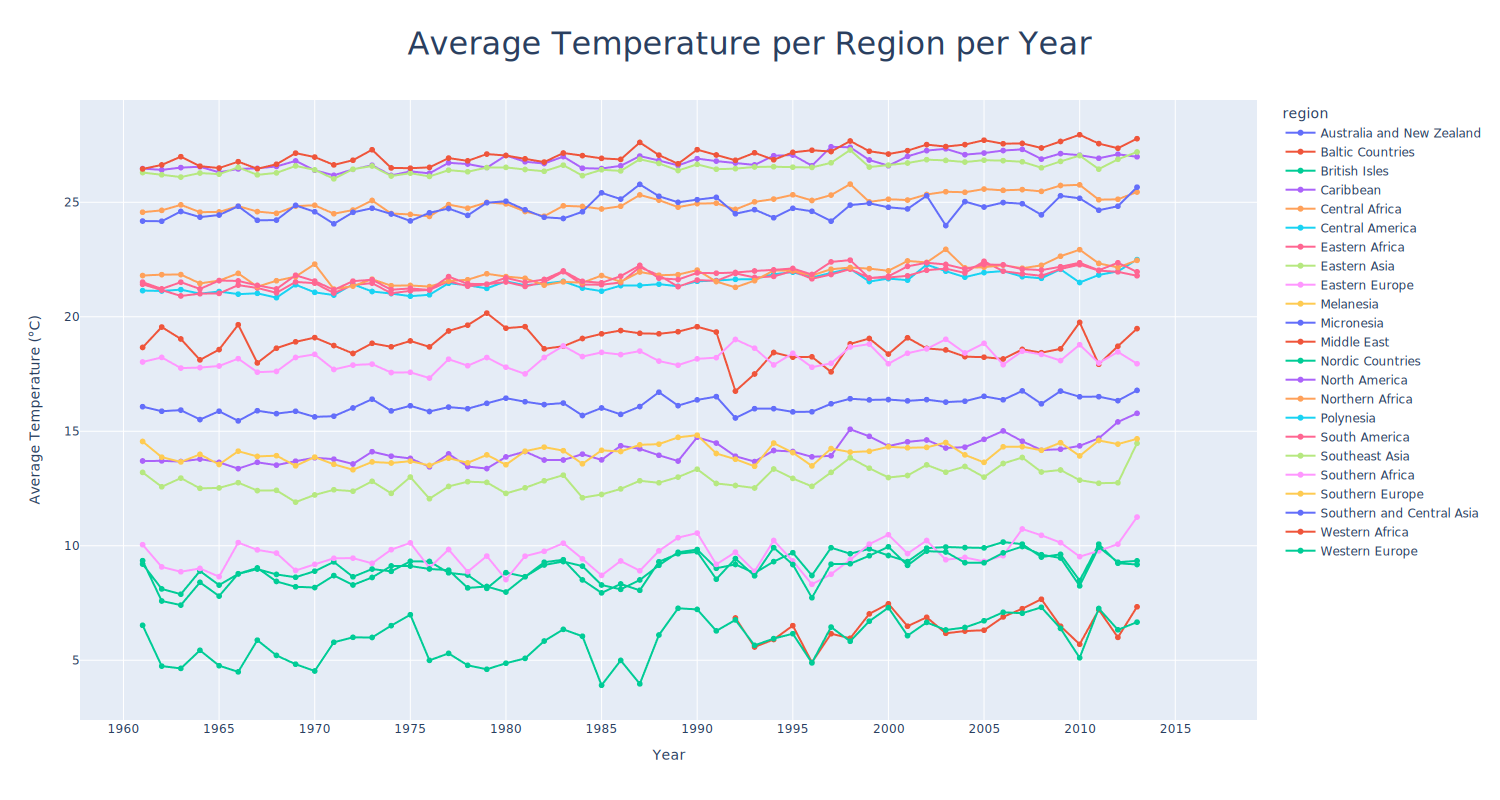

In [103]:
# Aggregate the average temperature by region and year
avg_temp_per_region_year = merged_df.groupby(['region', 'year'])['avg_temp'].mean().reset_index(name='average_temperature')

# Create the line chart
fig = px.line(avg_temp_per_region_year, 
              x='year', 
              y='average_temperature', 
              color='region', 
              labels={'average_temperature': 'Average Temperature', 'year': 'Year'},
              markers=True,
              title='Average Temperature per Region per Year')

# Update layout
fig.update_layout(
    width=1500, 
    height=800, 
    xaxis_title="Year",
    yaxis_title="Average Temperature (°C)",
    xaxis=dict(nticks=30),
    title={
        'text': 'Average Temperature per Region per Year',
        'y':0.96,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font_size': 32
    }
)

# Show the figure
fig.show()


### Average Precipitation per Region per Year

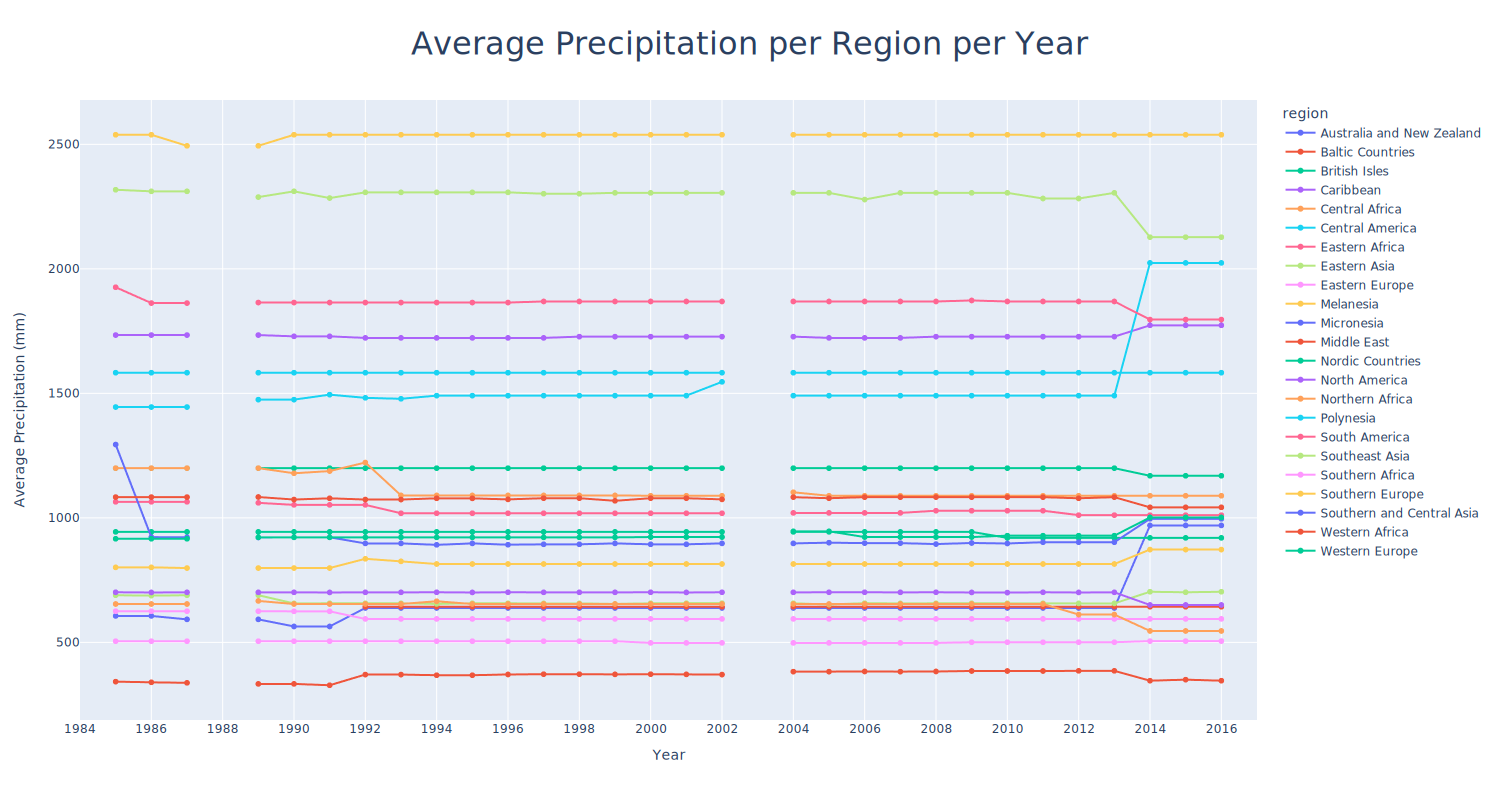

In [104]:
# Aggregate the average temperature by region and year
avg_prec_per_region_year = merged_df.groupby(['region', 'year'])['avg_prec_mm'].mean().reset_index(name='average_precip')

# Create the line chart
fig = px.line(avg_prec_per_region_year, 
              x='year', 
              y='average_precip', 
              color='region', 
              labels={'average_precip': 'Average Precipitation', 'year': 'Year'},
              markers=True,
              title='Average Precipitation per Region per Year')

# Update layout
fig.update_layout(
    width=1500, 
    height=800, 
    xaxis_title="Year",
    yaxis_title="Average Precipitation (mm)",
    xaxis=dict(nticks=30, range=[1984, 2017]),
    title={
        'text': 'Average Precipitation per Region per Year',
        'y':0.96,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font_size': 32
    }
)

# Show the figure
fig.show()


### Total Crop Yield by the Crop Type

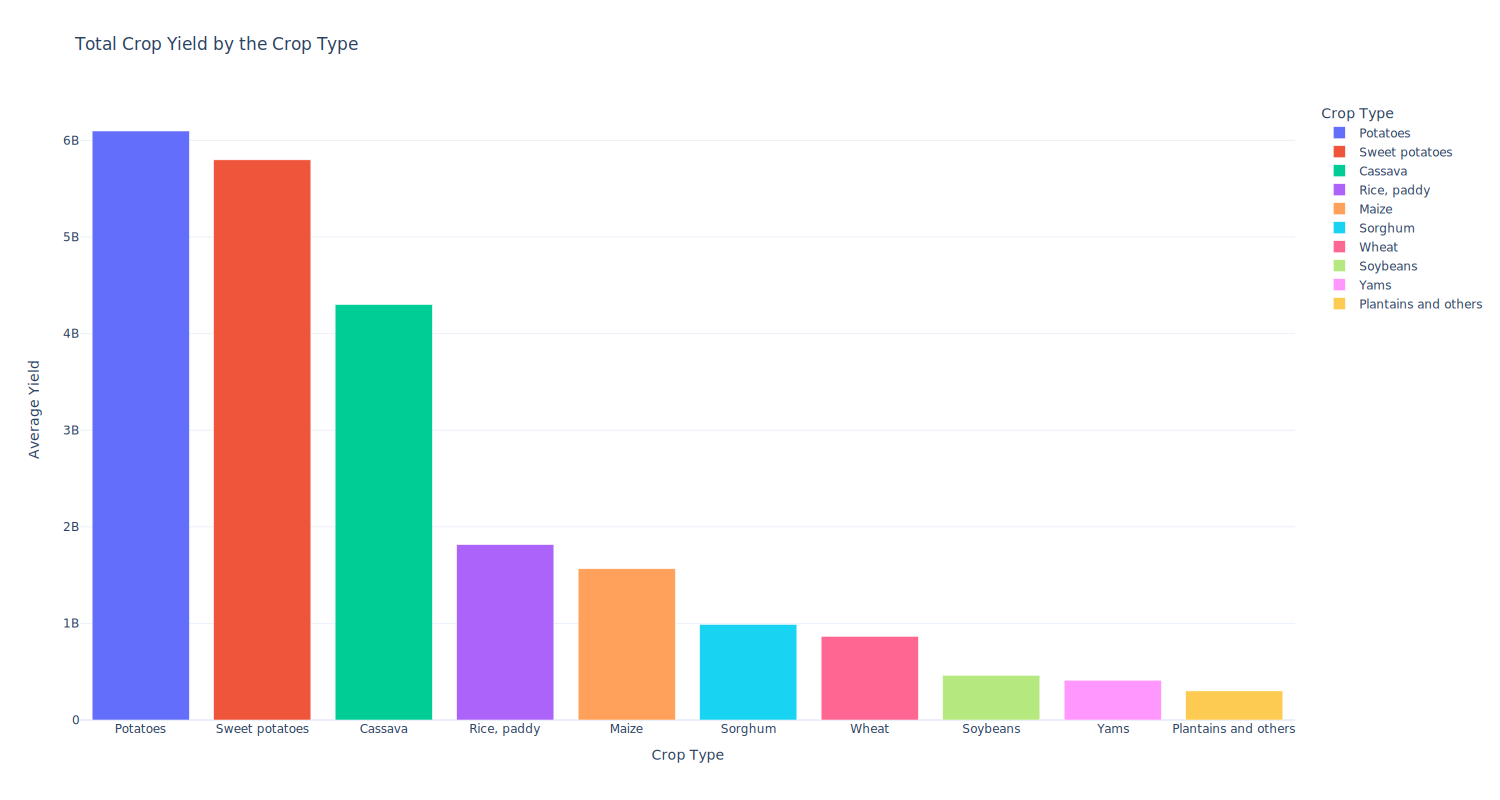

In [105]:
# Average crop yield by crop type
crop_grouped_data = merged_df.groupby('crop_type')['crop_yield'].sum().round(2).sort_values(ascending=False).to_frame().reset_index()

# Creating a bar chart
fig_bar = px.bar(crop_grouped_data, x='crop_type', y='crop_yield', title='Total Crop Yield by the Crop Type', 
                 labels={'crop_yield': 'Average Crop Yield', 'crop_type': 'Crop Type'}, 
                 color='crop_type',  # Optional: Color by crop type for better distinction
                 width=1500, height=800,)  # Display yield values on the bars

# Updating layout for aesthetics
fig_bar.update_layout(xaxis_title='Crop Type',
                      yaxis_title='Average Yield',
                      xaxis={'categoryorder':'total descending'},  # Ensures bars are sorted
                      template='plotly_white')

fig_bar.show()

### Total Crop Yield by the Region

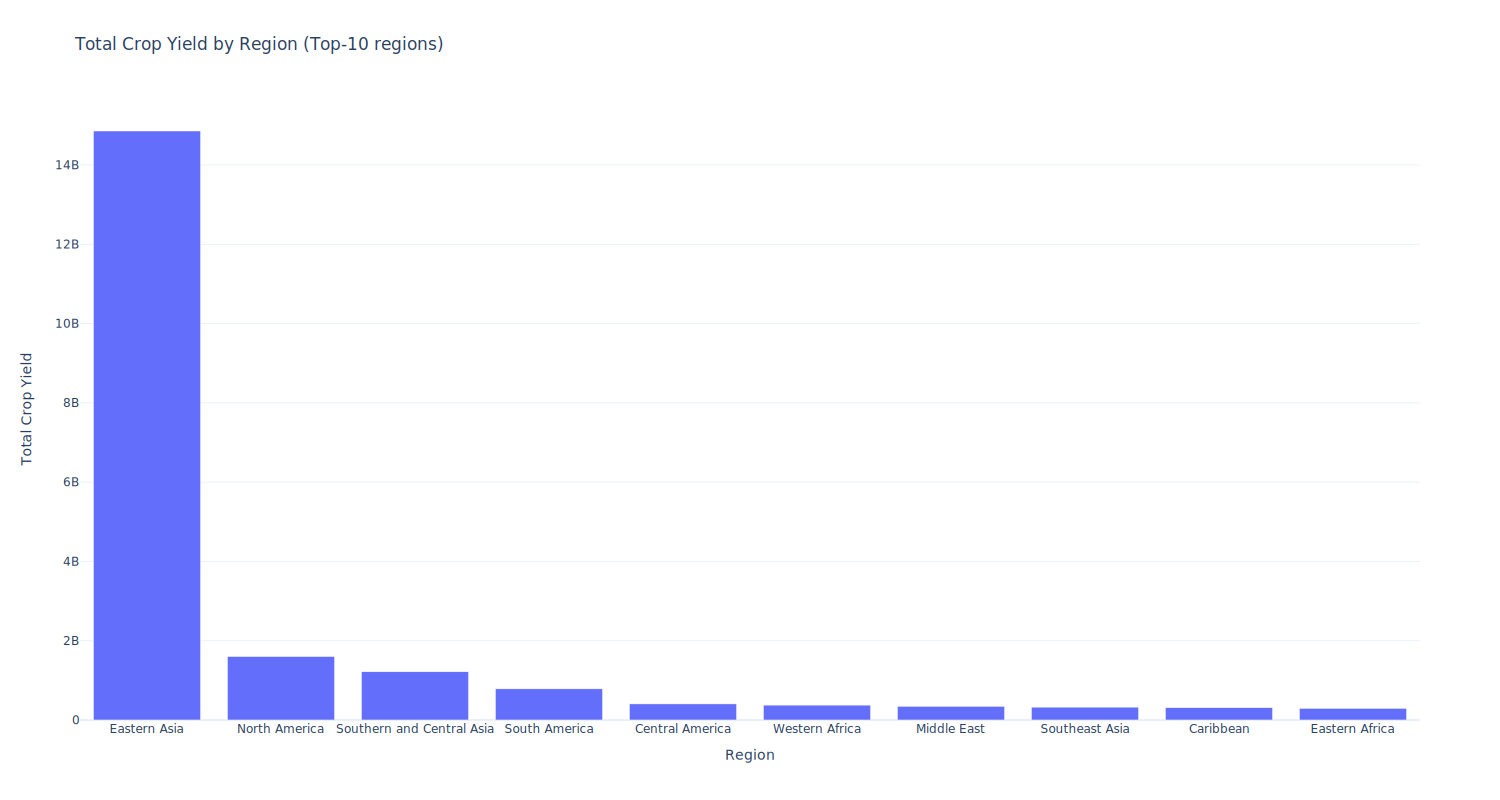

In [106]:
# Average crop yield by crop type
crop_grouped_data_2 = merged_df.groupby('region')['crop_yield'].sum().round(2).sort_values(ascending=False).to_frame().reset_index().head(10)

# Creating a bar chart
fig = px.bar(crop_grouped_data_2, x='region', y='crop_yield', title='Total Crop Yield by Region (Top-10 regions)', 
                 labels={'crop_yield': 'Total Crop Yield'},
                 width=1500, height=800)  # Display yield values on the bars

# Updating layout for aesthetics
fig.update_layout(xaxis_title='Region',
                      yaxis_title='Total Crop Yield',
                      xaxis={'categoryorder':'total descending'},  # Ensures bars are sorted
                      template='plotly_white')

fig.show()

### Total Crop Yield by the Country

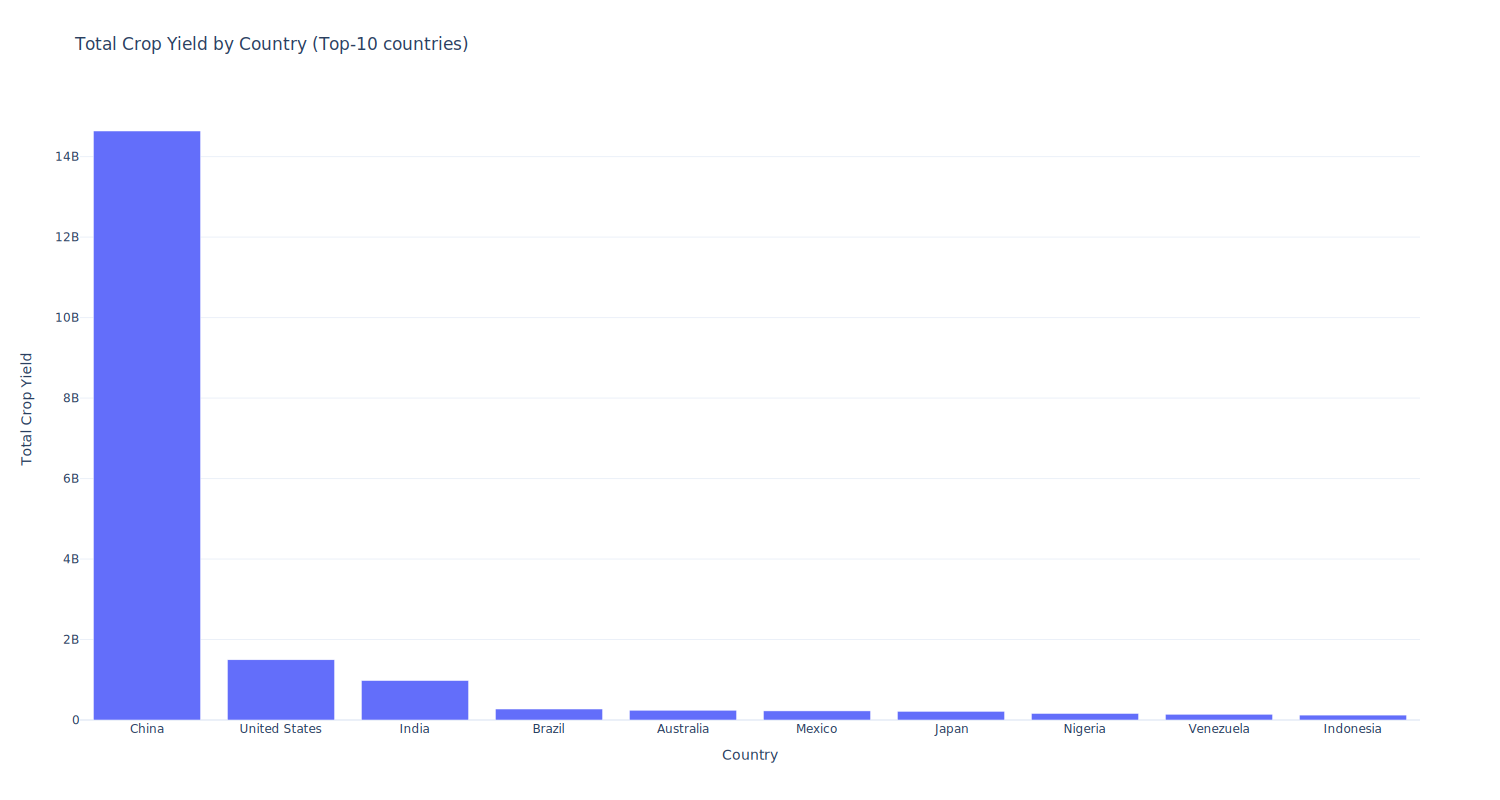

In [107]:
# Average crop yield by crop type
crop_grouped_data_3 = merged_df.groupby('country')['crop_yield'].sum().round(2).sort_values(ascending=False).to_frame().reset_index().head(10)

# Creating a bar chart
fig = px.bar(crop_grouped_data_3, x='country', y='crop_yield', title='Total Crop Yield by Country (Top-10 countries)', 
                 labels={'crop_yield': 'Total Crop Yield'},
                 width=1500, height=800)  # Display yield values on the bars

# Updating layout for aesthetics
fig.update_layout(xaxis_title='Country',
                      yaxis_title='Total Crop Yield',
                      xaxis={'categoryorder':'total descending'},  # Ensures bars are sorted
                      template='plotly_white')

fig.show()

# Step 5: Preparations for the ML part & some data corrections

## 5.1 Final data processing

### Manage the `Precipitation` missing values

### Linear Interpolation for the missing data that is in the middle of the dataset

In [108]:
# Sort the DataFrame by country and year so the interpolation should consider country patterns
merged_df = merged_df.sort_values(by=['country', 'year'])

# Apply linear interpolation within each country, using transform to maintain the DataFrame's original index
merged_df['avg_prec_mm'] = merged_df.groupby('country')['avg_prec_mm'].transform(lambda group: group.interpolate(method='linear'))

### Fill in the data in the beginning of the dataset by using the median values per each country

In [109]:
# Compute the median precipitation for each country
median_precipitation = merged_df.groupby('country')['avg_prec_mm'].median()

# Fill NaN values with the median for each country
merged_df['avg_prec_mm'] = merged_df.groupby('country')['avg_prec_mm'].transform(lambda x: x.fillna(median_precipitation[x.name]))

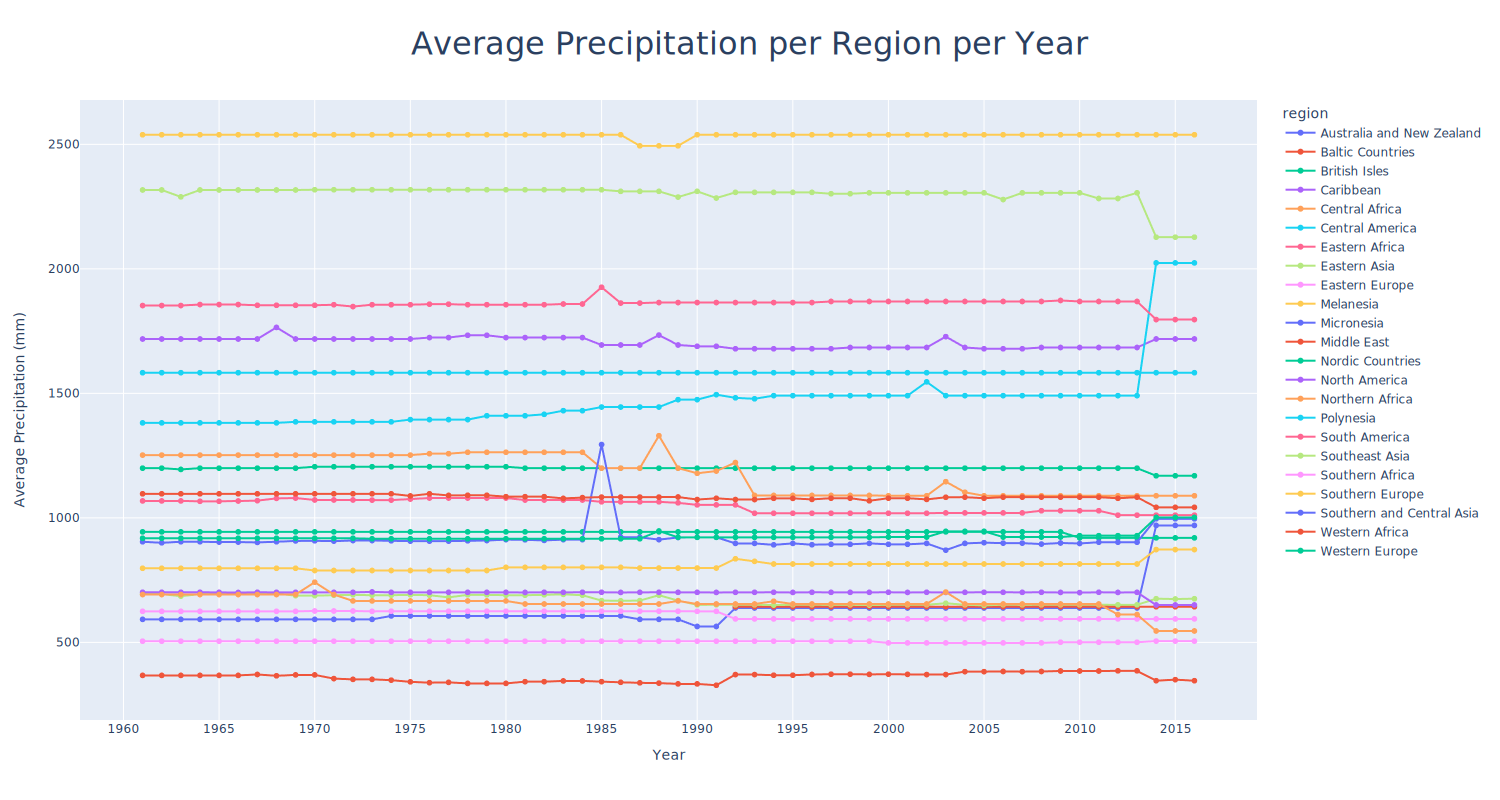

In [110]:
# Aggregate the average temperature by region and year
avg_prec_per_region_year = merged_df.groupby(['region', 'year'])['avg_prec_mm'].mean().reset_index(name='average_precip')

# Create the line chart
fig = px.line(avg_prec_per_region_year, 
              x='year', 
              y='average_precip', 
              color='region', 
              labels={'average_precip': 'Average Precipitation', 'year': 'Year'},
              markers=True,
              title='Average Precipitation per Region per Year')

# Update layout
fig.update_layout(
    width=1500, 
    height=800, 
    xaxis_title="Year",
    yaxis_title="Average Precipitation (mm)",
    xaxis=dict(nticks=30),
    title={
        'text': 'Average Precipitation per Region per Year',
        'y':0.96,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font_size': 32
    }
)

# Show the figure
fig.show()

## 5.2 Create helper functions

### Function: data_splitter()
Split our dataset in parts. We will use cross-validation, that is why we do not need a separate validation dataset.

Train: 80%
Test: 20% (to test the final model)

In [111]:
def data_splitter(data, testSize = 0.2):

    # splitting the train-test data
    train, test = train_test_split(data, test_size=testSize, random_state=42)

    # assigning features and targets for train and test samples
    X_train = train.drop('crop_yield', axis=1)
    y_train = train['crop_yield']
    
    X_test = test.drop('crop_yield', axis=1)
    y_test = test['crop_yield']

    print('X_train: {0} ({1}%)'.format(X_train.shape[0], (X_train.shape[0]/data.shape[0])*100))
    print('y_train: {0} ({1}%)'.format(y_train.shape[0], (y_train.shape[0]/data.shape[0])*100))
    print()
    print('X_test: {0} ({1}%)'.format(X_test.shape[0], (X_test.shape[0]/data.shape[0])*100))
    print('y_test: {0} ({1}%)'.format(y_test.shape[0], (y_test.shape[0]/data.shape[0])*100))
    
    return X_train, y_train, X_test, y_test

### Function: plot_real_vs_pred()

Plotting real and predicted data.


In [112]:
def plot_real_vs_pred(model_name, y_real, y_pred):
    plt.style.use('ggplot')
    reg_real_vs_pred = pd.DataFrame({'Actual': y_real, 'Predicted': y_pred})
    reg_real_vs_pred = reg_real_vs_pred.head(40)
    reg_real_vs_pred.plot(kind='bar', title='MODEL: '+model_name, figsize=(18,5))
    plt.show()

In [113]:
merged_df.sample(5)

,country,crop_type,year,crop_yield,avg_temp,pest_used_tonnes,avg_prec_mm,region
1822,Argentina,"Rice, paddy",1965,39423,17.625000,NaN,591.0,South America
319443,India,Potatoes,1989,159290,25.765625,NaN,788.0,Southern and Central Asia
311669,Greece,Potatoes,2005,200680,17.906250,12083.0,652.0,Southern Europe
83846,China,Soybeans,2012,18144,15.750000,56.0,645.0,Eastern Asia
106624,China,"Rice, paddy",1978,18817,15.250000,NaN,645.0,Eastern Asia


### Function: basemodel_predict()

Get predictions of the baseline model

In [114]:
def basemodel_predict(base, X_test):
    # Preparing the output array
    output = []
    
    # Iterate through the test dataset
    for index, row in X_test.iterrows():
        # Fetching the baseline average crop yield from the DataFrame
        mask = (base['country'] == row['country']) & (base['crop_type'] == row['crop_type'])
        filtered_base = base[mask]
        
        if not filtered_base.empty:
            average_yield = filtered_base['crop_yield'].iloc[0]
            output.append(int(average_yield))
        else:
            # Handle missing data if no matches found for the country and crop type combination
            default_value = base['crop_yield'].mean()
            output.append(int(default_value))

    return np.array(output)

### Function: get_metrics()

Function to calculate all relevant metrics.

Inputs: model name, real target values, predicted values.
Outputs: model name, MAE, RMSE, R^2, R (correlation).

In [115]:
def get_metrics(model_name, y_real, y_pred, to_print=True):
    # MAE: same units as target variable. It is more robust to outliers
    MAE = mean_absolute_error(y_real, y_pred)
    
    if to_print:
        print(f'MODEL: {model_name}')
        print(f'MAE: {round(MAE, 2)}')
    
    return model_name, MAE

### Function: compare_model_metrics()

Given a list of 'model_metrics', obtained from the function get_metrics(), this function creates several bar plots to compare metrics from different models and choose the best one

In [116]:
def compare_model_metrics(mod_metric_list):
    plt.style.use('ggplot')

    # Initialize empty DataFrame for MAE
    df_MAE = pd.DataFrame(columns=['MAE'])

    # List to store DataFrame entries before concatenating
    entries_MAE = []

    # Populate entries for MAE
    for mod in mod_metric_list:
        entries_MAE.append({'MAE': mod[1]})

    # Convert list to DataFrame
    df_MAE = pd.DataFrame(entries_MAE, index=[mod[0] for mod in mod_metric_list])

    # Sort DataFrame
    df_MAE.sort_values('MAE', ascending=True, inplace=True)

    # Plotting
    f, ax = plt.subplots(figsize=(8, len(mod_metric_list) * 0.75))
    df_MAE.plot(kind='barh', ax=ax, color='lightcoral', title='Model Comparison - MAE', legend=False)

    # Annotate each bar in the plot
    for p in ax.patches:
        ax.annotate(format(p.get_width(), '.2f'),
                    (p.get_x() + p.get_width(), p.get_y() + p.get_height() / 2),
                    xytext=(5, 0), textcoords='offset points', ha='left', va='center')

    plt.tight_layout()
    plt.show()

## 5.3 Label Encoding of the categorical columns

Since we have here 3 categorical columns: `country`, `crop_type`, and `region`. 
* country: 198 unique names
* crop_type: 8 unique categories
* region: 23 unique regions

Since these data are not ordered, `One-Hot-Encoding` will be more preferable ranther than the `Label-Encoding`. Hovewer, considering the amount of unique categories, our dataset dimensionality will become too huge. 
In order to avoid these issues I will use ML algorythms that can handle categorical variables without encoding.

In [117]:
merged_df.head()

,country,crop_type,year,crop_yield,avg_temp,pest_used_tonnes,avg_prec_mm,region
0,Afghanistan,Maize,1961,14000,14.226562,NaN,327.0,Southern and Central Asia
56,Afghanistan,Potatoes,1961,86667,14.226562,NaN,327.0,Southern and Central Asia
112,Afghanistan,"Rice, paddy",1961,15190,14.226562,NaN,327.0,Southern and Central Asia
168,Afghanistan,Wheat,1961,10220,14.226562,NaN,327.0,Southern and Central Asia
1,Afghanistan,Maize,1962,14000,14.101562,NaN,327.0,Southern and Central Asia


## 5.4 Fill in missing regions for the CatBoost

In [118]:
merged_df.region = merged_df.region.astype(str).fillna('missing').astype('category')

## 5.5 Split the data

In [119]:
X_train, y_train, X_test, y_test = data_splitter(merged_df)

X_train: 228067 (79.9999298452386%)
y_train: 228067 (79.9999298452386%)

X_test: 57017 (20.000070154761403%)
y_test: 57017 (20.000070154761403%)


# Task 6: the ML part
This task is a regression problem.

For our research we will use Gradient-Boosted Decision Trees (GBDT), and XGBoost (eXtreme Gradient Boosting) models together with MAE (mean absolute error), metric since it has shown good results for the similar task, according to this article. Random Forest Regressor will also be used since it often gives decent results from my experience. Additionally, we will also use CatBoost.

# 6.1 Baseline Model

Let's take an average crop yield per country and crop type as our baseline model. This will help us later to check the sanity of other models that we have trained.

In [120]:
baseline_model = merged_df.groupby(['country', 'crop_type'])['crop_yield'].mean().round(1)

baseline_model = baseline_model.reset_index()

In [121]:
baseline_model.head()

,country,crop_type,crop_yield
0,Afghanistan,Cassava,NaN
1,Afghanistan,Maize,17194.6
2,Afghanistan,Plantains and others,NaN
3,Afghanistan,Potatoes,136328.0
4,Afghanistan,"Rice, paddy",22194.1


### Baseline model predictions

In [122]:
base_y_pred = basemodel_predict(baseline_model, X_test)
print(base_y_pred)

[167811  35435   8345 ...  17230 167811  50248]


### Get metrics and plot Actual vs Predicted value

MODEL: Baseline Model
MAE: 18161.49


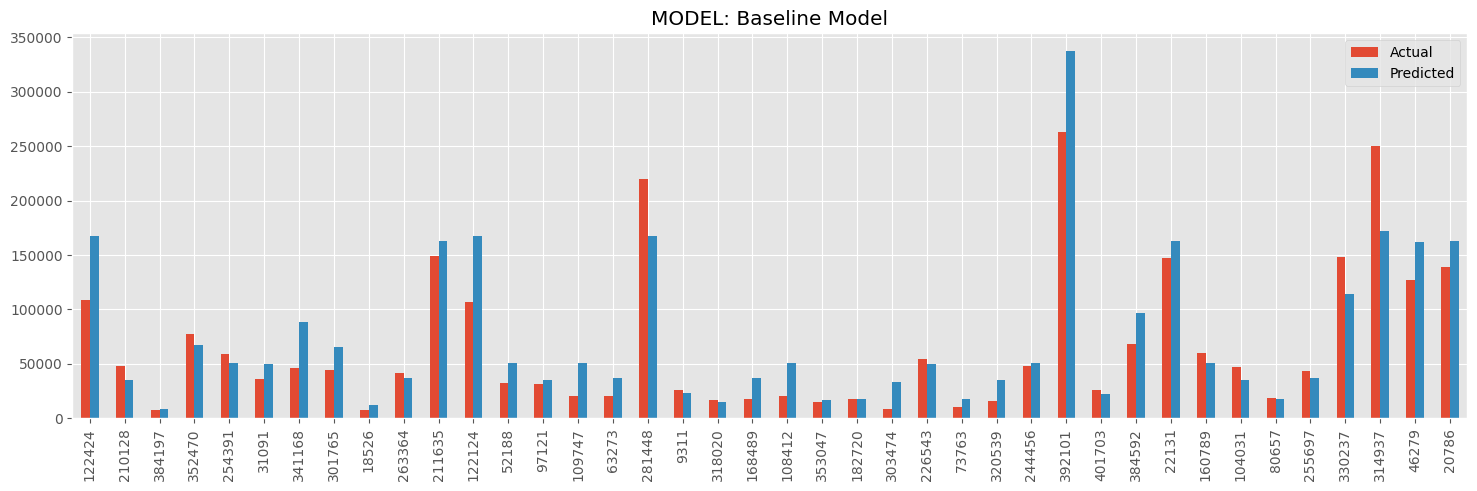

In [123]:
base_metrics = get_metrics('Baseline Model',y_test, base_y_pred)

plot_real_vs_pred('Baseline Model', y_test, base_y_pred)

## 6.2 XGBoost (eXtreme Gradient Boosting)

In [124]:
# Create dataframe to write down the results
xgb_result_df = pd.DataFrame(columns=['n_estimators', 'learning_rate', 'MAE'])

# Initialize variables to track the best model and metrics
best_model_xgb = None
best_score = float('inf')
best_params = {}

# Parameter grid
n_estimators_range = [10, 20, 30, 40, 50, 100, 200, 300, 500, 800]  # Number of boosting rounds
learning_rates = [0.1, 0.2, 0.3, 0.4]  # Learning rate or eta

# Explore the parameter grid
for n_estimators in n_estimators_range:
    for learning_rate in learning_rates:
        model = XGBRegressor(n_estimators=n_estimators, learning_rate=learning_rate, random_state=42, n_jobs=-1, enable_categorical=True)
        
        # Perform cross-validation and calculate MAE
        scores = cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_absolute_error')
        mean_MAE = -np.mean(scores)  # Convert from negative to positive MAE
        
        # Update the results DataFrame
        new_row = {'n_estimators': n_estimators, 'learning_rate': learning_rate, 'MAE': round(mean_MAE, 2)}
        xgb_result_df = pd.concat([xgb_result_df, pd.DataFrame([new_row])], ignore_index=True)
        
        # Update the best model if the current MAE is lower
        if mean_MAE < best_score:
            best_model_xgb = model
            best_score = mean_MAE
            best_params = {'n_estimators': n_estimators, 'learning_rate': learning_rate}

# Fit the best model
best_model_xgb.fit(X_train, y_train)

# Optionally print or visualize all results
print(f"Best Model Parameters: {best_params}")

# Get predictions of the best model
xgb_y_pred = best_model_xgb.predict(X_test)

# Evaluate the best model
metrics_xgb = get_metrics('XGBoost', y_test, xgb_y_pred)

Best Model Parameters: {'n_estimators': 800, 'learning_rate': 0.1}
MODEL: XGBoost
MAE: 12045.5


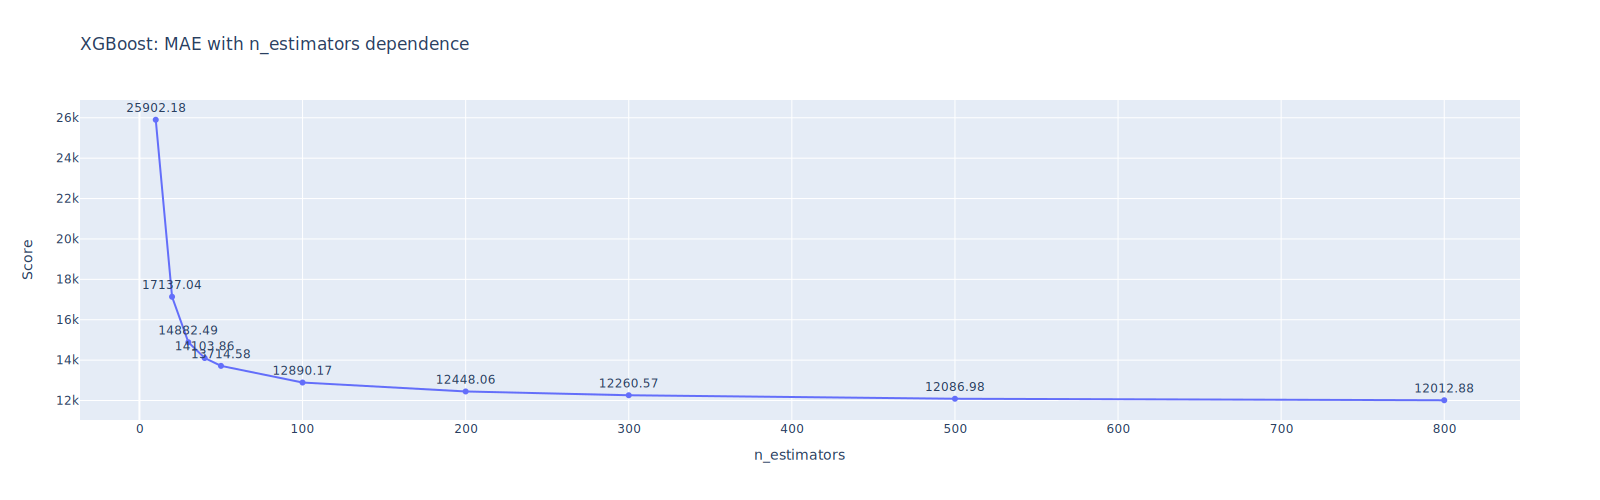

In [125]:
# Filter only for the best learning_rate
xgb_result_df = xgb_result_df[xgb_result_df['learning_rate']==best_params['learning_rate']]

fig = px.line(xgb_result_df, x='n_estimators', y='MAE', markers=True,
              title='XGBoost: MAE with n_estimators dependence', text='MAE')
fig.update_layout(xaxis_title="n_estimators", yaxis_title="Score")
fig.update_traces(textposition='top center')
fig.show(renderer="svg", width = 1600, height = 500)

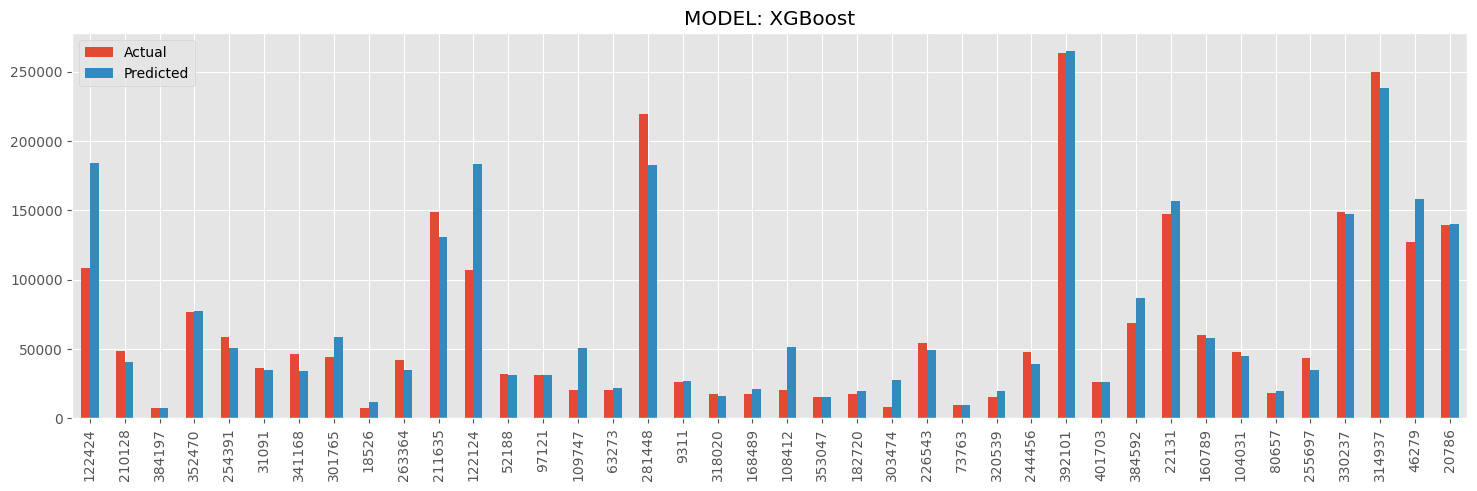

In [126]:
model_name = 'XGBoost'

plot_real_vs_pred(model_name, y_test, xgb_y_pred)

## 6.3 CatBoost

In [127]:
# Create dataframe to write down the results
cat_result_df = pd.DataFrame(columns=['n_estimators', 'learning_rate', 'MAE'])

# Initialize variables to track the best model and metrics
best_model_cat = None
best_score = float('inf')
best_params = {}

# Identify categorical features
categorical_features = ['country', 'crop_type', 'region']

# Parameter grid
n_estimators_range = [10, 20, 30, 40, 50, 100, 200, 300, 500, 800]  # Number of boosting rounds
learning_rates = [0.1, 0.2, 0.3, 0.4]  # Learning rate

# Explore the parameter grid
for n_estimators in n_estimators_range:
    for learning_rate in learning_rates:
        model = CatBoostRegressor(n_estimators=n_estimators, learning_rate=learning_rate, 
                                  random_state=42, verbose=0, thread_count=-1, cat_features=categorical_features)

        # Perform cross-validation and calculate MAE
        scores = cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_absolute_error')
        mean_MAE = -np.mean(scores)  # Convert from negative to positive MAE

        # Update the results DataFrame
        new_row = {'n_estimators': n_estimators, 'learning_rate': learning_rate, 'MAE': round(mean_MAE, 2)}
        cat_result_df = pd.concat([cat_result_df, pd.DataFrame([new_row])], ignore_index=True)

        # Update the best model if the current MAE is lower
        if mean_MAE < best_score:
            best_model_cat = model
            best_score = mean_MAE
            best_params = {'n_estimators': n_estimators, 'learning_rate': learning_rate}

# Fit the best model
best_model_cat.fit(X_train, y_train)

# Optionally print or visualize all results
print(f"Best Model Parameters: {best_params}")

# Get predictions of the best model
cat_y_pred = best_model_cat.predict(X_test)

# Evaluate the best model
metrics_cat = get_metrics('CatBoost', y_test, cat_y_pred)


Best Model Parameters: {'n_estimators': 800, 'learning_rate': 0.4}
MODEL: CatBoost
MAE: 13236.74


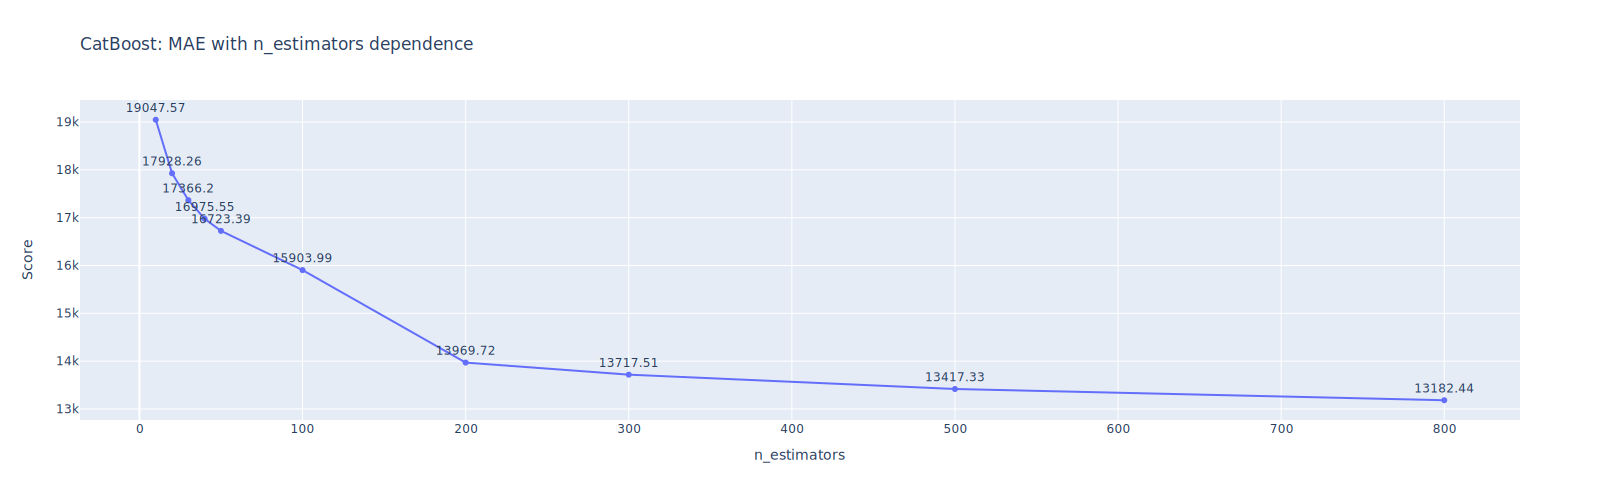

In [128]:
# Filter only for the best learning_rate
cat_result_df = cat_result_df[cat_result_df['learning_rate']==best_params['learning_rate']]

fig = px.line(cat_result_df, x='n_estimators', y='MAE', markers=True,
              title='CatBoost: MAE with n_estimators dependence', text='MAE')
fig.update_layout(xaxis_title="n_estimators", yaxis_title="Score")
fig.update_traces(textposition='top center')
fig.show(renderer="svg", width = 1600, height = 500)

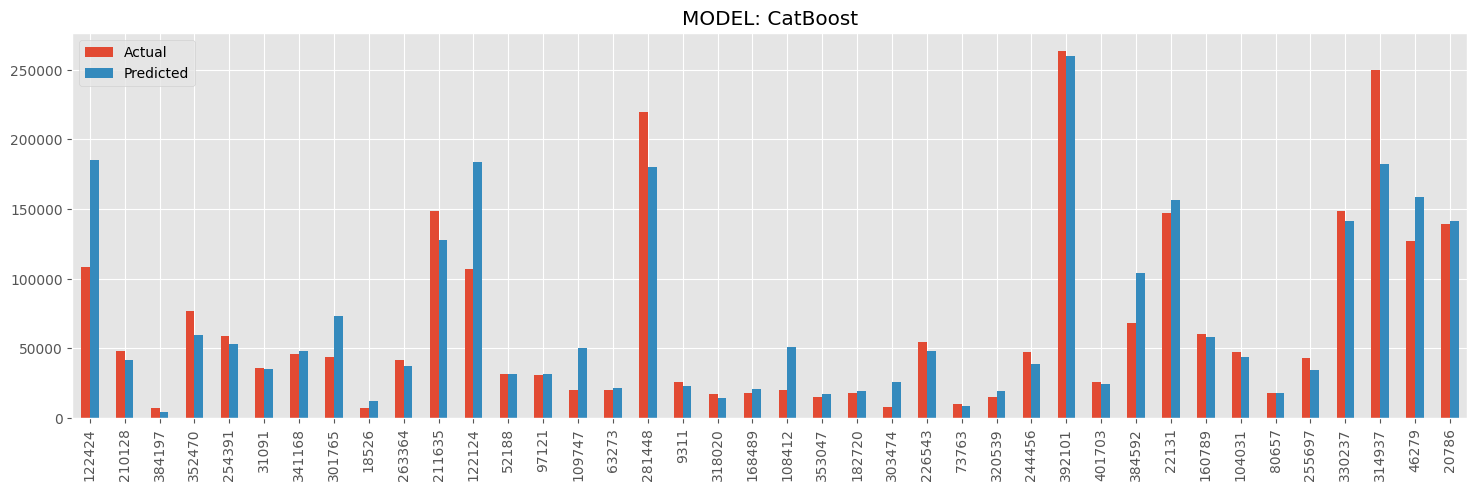

In [129]:
model_name = 'CatBoost'

plot_real_vs_pred(model_name, y_test, cat_y_pred)

## 6.4 LightGBM

In [130]:
# Create dataframe to write down the results
lgb_result_df = pd.DataFrame(columns=['n_estimators', 'learning_rate', 'MAE'])

# Initialize variables to track the best model and metrics
best_model_lgb = None
best_score = float('inf')
best_params = {}

# Parameter grid
n_estimators_range = [10, 20, 30, 40, 50, 100, 200, 300, 500, 800]  # Number of boosting rounds
learning_rates = [0.1, 0.2, 0.3, 0.4]  # Learning rate

# Explore the parameter grid
for n_estimators in n_estimators_range:
    for learning_rate in learning_rates:
        model = lgb.LGBMRegressor(n_estimators=n_estimators, learning_rate=learning_rate, 
                                  random_state=42, n_jobs=-1, force_row_wise=True, verbose=-1)

        # Perform cross-validation and calculate MAE
        scores = cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_absolute_error')
        mean_MAE = -np.mean(scores)  # Convert from negative to positive MAE

        # Update the results DataFrame
        new_row = {'n_estimators': n_estimators, 'learning_rate': learning_rate, 'MAE': round(mean_MAE, 2)}
        lgb_result_df = pd.concat([lgb_result_df, pd.DataFrame([new_row])], ignore_index=True)

        # Update the best model if the current MAE is lower
        if mean_MAE < best_score:
            best_model_lgb = model
            best_score = mean_MAE
            best_params = {'n_estimators': n_estimators, 'learning_rate': learning_rate}

# Fit the best model
best_model_lgb.fit(X_train, y_train, categorical_feature=categorical_features)

# Optionally print or visualize all results
print(f"Best Model Parameters: {best_params}")

# Get predictions of the best model
lgb_y_pred = best_model_lgb.predict(X_test)

# Evaluate the best model
metrics_lgb = get_metrics('LightGBM', y_test, lgb_y_pred)

Best Model Parameters: {'n_estimators': 800, 'learning_rate': 0.2}
MODEL: LightGBM
MAE: 12211.09


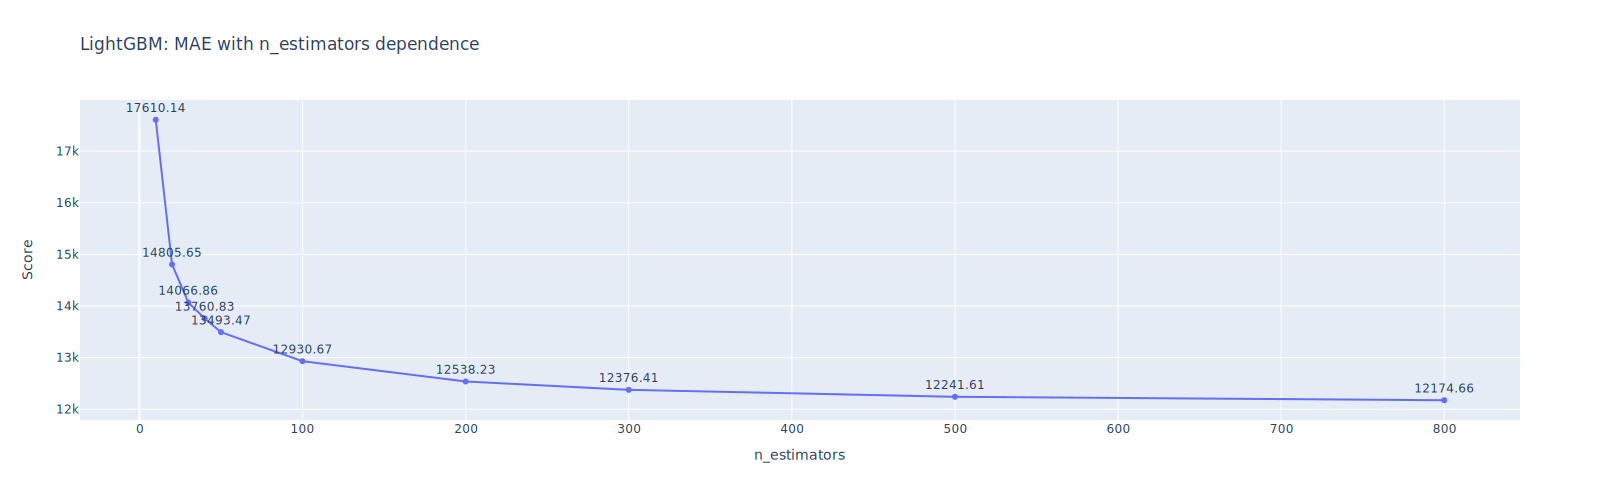

In [131]:
# Filter only for the best learning_rate
lgb_result_df = lgb_result_df[lgb_result_df['learning_rate']==best_params['learning_rate']]

fig = px.line(lgb_result_df, x='n_estimators', y='MAE', markers=True,
              title='LightGBM: MAE with n_estimators dependence', text='MAE')
fig.update_layout(xaxis_title="n_estimators", yaxis_title="Score")
fig.update_traces(textposition='top center')
fig.show(renderer="svg", width = 1600, height = 500)

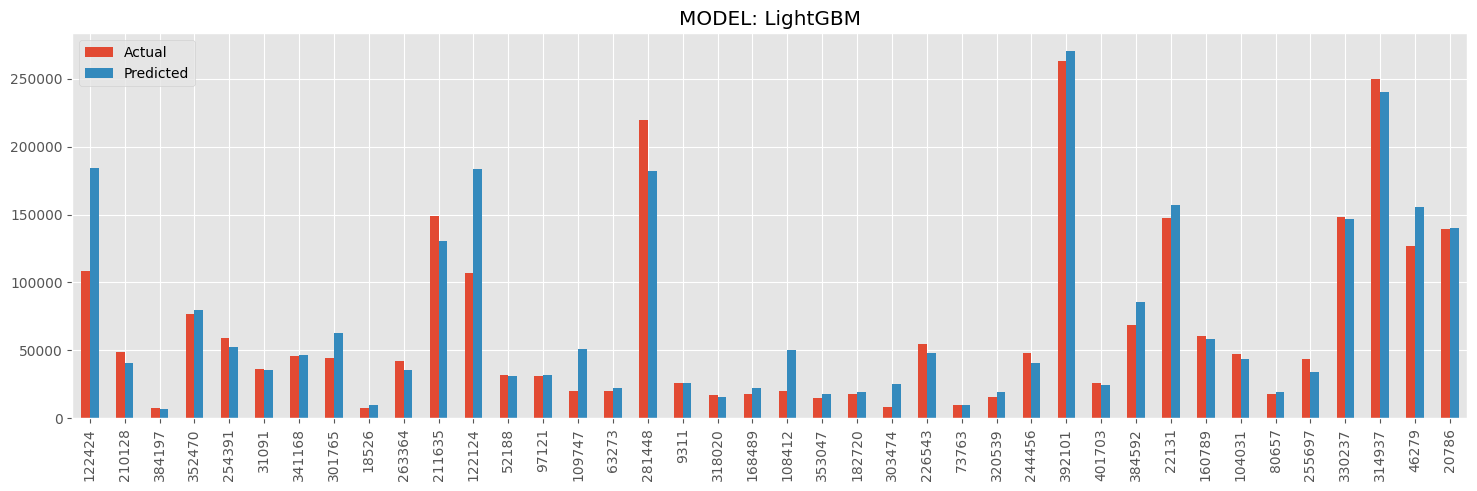

In [132]:
model_name = 'LightGBM'

plot_real_vs_pred(model_name, y_test, lgb_y_pred)

## 6.5 Compare models' metrics

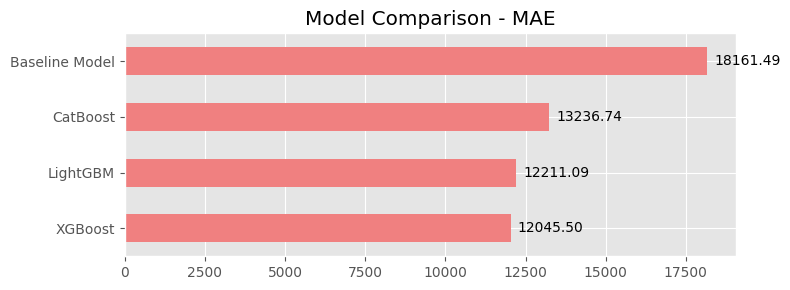

In [133]:
compare_model_metrics([base_metrics, metrics_xgb, metrics_cat, metrics_lgb])

## 6.6 Relative importance of the features for the best model

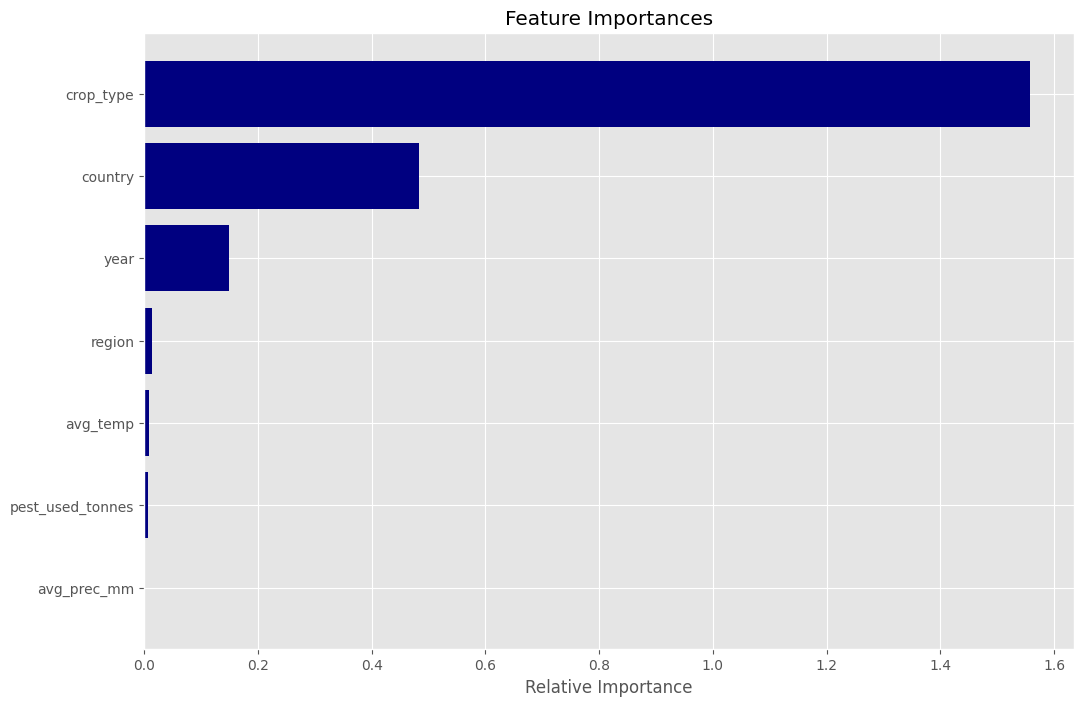

In [134]:
result = permutation_importance(best_model_xgb, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

# Extract feature importances and their indices
importances = result.importances_mean
indices = np.argsort(importances)

# Get feature names sorted by importance
features = X_test.columns.tolist()
sorted_features = [features[i] for i in indices]

plt.figure(figsize=(12, 8))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='navy', align='center')
plt.yticks(range(len(indices)), sorted_features)
plt.xlabel('Relative Importance')
plt.show()


# Step 7: Final Conclusion

**The data cleaning & merging part:**
1. The data was cleaned, merged, and its dtypes were also optimized. Additionally, the countries' names were standardized. 
2. Some missing values were substituted (e.g. precipitation).

**Insights from the EDA:**

1. Top 3 crops by total crop yields are:
    * Potato
    * Sweet potato
    * Casava
2. Eastern Asia is the biggest crops procucer by far.
3. Average temperature and average precipitation have pretty strong positive correlation (0.46).

**The ML part:**
1. Several ML techniques were tested together with the baseline model: XGBoost, Catboost and LightGBM.
2. MAE was chosen as the main metric.
3. XGBoost has shown the best results with the lowest MAE.
4. crop_type, country and year are the top-3 parameters that influence the prediction.
5. Such a huge MAE can be caused by the errors from China.

Main question: **Can we model & predict the crop yield (per year and country) in the hypothetical Use Case of rolling out the model on an unseen (out of data) country?**

We can use clustering for predictions for an unseen country (in this case I have used simple regions). We can estimate average precipitation and average temperature depending on the region or cluster countries depending on their geographical features (latitude and longitude). Additionally, some extra feature engineering might help in this task.


### What could be further improved:
1. More dataset cleaning and processing will be helpful since some data is still missing and requires a lot of time to handle (e.g. missing precipitation or temperatures for some years and countries).
2. Additional feature engineering may also help: amount of land suitable for agriculture, soil type, weather conditions (a number of rainy and solar days), population, gdp per capita, etc.
3. Introducing moving averages and lags per year and country might also improve our predictions.
3. More intensive hyperparameter tuning using GPUs could enable the training of even better models.
4. Additional metrics might be helpful in our research.
5. GridSearchCV could also be used to streamline the search for better parameters.
6. Other ML or ANN approaches might also give better results.
7. Other factors e.g. training time, and prediction time might also be taken into account in case of more thorough research.
8. Maybe excluding some countries that hive too high values (China) will result in better overall predictions for other countries.